# Import Libraries

In [ ]:
# For drive access
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import numpy as np
import pandas as pd

# for loading the pickle files with features and labels
import pickle

# For audio
from IPython.display import Audio
import librosa

# For preprocessing
from sklearn.preprocessing import OneHotEncoder

# For modeling
import tensorflow as tf
from sklearn.metrics import classification_report

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load features and labels from train and val pickle

In [ ]:
with open('/content/drive/MyDrive/project/train_val_features_pkl/train_val_5_sec_audio_features_avgpooled.pkl', 'rb') as file:
  audio_df = pickle.load(file)

In [ ]:
audio_df

{'train': {'mfcc': array([[0.3391694 , 0.40924874, 0.5358972 , ..., 0.54475796, 0.50564116,
          0.46894422],
         [0.33568618, 0.41750646, 0.53681815, ..., 0.542808  , 0.5288323 ,
          0.45956683],
         [0.36065662, 0.41422567, 0.5833725 , ..., 0.52050847, 0.55034566,
          0.44331655],
         ...,
         [0.59729165, 0.4938564 , 0.38847885, ..., 0.4174044 , 0.4665348 ,
          0.39914683],
         [0.6012123 , 0.51702017, 0.3863889 , ..., 0.42538506, 0.46877104,
          0.41223076],
         [0.6082435 , 0.5434134 , 0.37211478, ..., 0.4219473 , 0.46813804,
          0.40352035]], dtype=float32),
  'chroma': array([[0.3414871 , 0.35261095, 0.38855013, ..., 0.37608668, 0.36091387,
          0.37655085],
         [0.39570332, 0.35266703, 0.3601897 , ..., 0.3406976 , 0.36317727,
          0.4071223 ],
         [0.44144076, 0.37290844, 0.3611199 , ..., 0.27120224, 0.36760825,
          0.40015313],
         ...,
         [0.5226286 , 0.5496563 , 0.5463212 , 

In [ ]:
with open('/content/drive/MyDrive/project/train_val_features_pkl/train_val_5_sec_non_audio_features.pkl', 'rb') as file:
  non_audio_df = pickle.load(file)

In [ ]:
non_audio_df

{'train': {'type': array(['call', 'call', 'call', ..., 'call', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([5. , 5. , 5. , ..., 3.5, 3.5, 3.5]),
  'label': array([2, 2, 2, ..., 2, 2, 2])},
 'val': {'type': array(['call', 'call', 'call', ..., 'call', 'call', 'call'], dtype='<U5'),
  'continent': array(['EUROPE', 'EUROPE', 'EUROPE', ..., 'EUROPE', 'EUROPE', 'EUROPE'],
        dtype='<U8'),
  'rating': array([4. , 4. , 4. , ..., 2.5, 2.5, 2.5]),
  'label': array([1, 1, 1, ..., 1, 1, 1])}}

## confirm the audio features and non_audio features labels line-up

In [ ]:
assert np.array_equal(audio_df['train']['label'], non_audio_df['train']['label'])

In [ ]:
assert np.array_equal(audio_df['val']['label'], non_audio_df['val']['label'])

# Shuffle the data

In [ ]:
def shuffle_data(audio_features, non_audio_features):
  input_len = len(audio_features['label'])
  input_indices = np.random.permutation(input_len)
  audio_features = {key: np.array([audio_features[key][i] for i in input_indices]) for key in audio_features}
  non_audio_features = {key: np.array([non_audio_features[key][i] for i in input_indices]) for key in non_audio_features}

  return audio_features, non_audio_features

In [ ]:
audio_df['train'], non_audio_df['train'] = shuffle_data(audio_df['train'], non_audio_df['train'])

In [ ]:
for key in audio_df['train'].keys():
  display(key)
  display(audio_df['train'][key].shape)
  display(audio_df['train'][key][:5])

'mfcc'

(8236, 20)

array([[0.5930482 , 0.5446129 , 0.5541285 , 0.48910537, 0.46473232,
        0.52995604, 0.3412822 , 0.5908589 , 0.4090115 , 0.4770792 ,
        0.4421674 , 0.42848274, 0.58285373, 0.34280908, 0.4889214 ,
        0.40838414, 0.5901443 , 0.3984707 , 0.5321854 , 0.47193125],
       [0.5583726 , 0.6627083 , 0.7213851 , 0.5947183 , 0.5406521 ,
        0.5941916 , 0.46243194, 0.53175604, 0.5125722 , 0.40548292,
        0.5835187 , 0.3763164 , 0.55381906, 0.39023238, 0.50294274,
        0.4772012 , 0.48370144, 0.57025504, 0.5074533 , 0.59585416],
       [0.47997722, 0.5521823 , 0.4166696 , 0.34959945, 0.34506327,
        0.08010074, 0.2823403 , 0.12846121, 0.24023311, 0.17793003,
        0.24551171, 0.2798677 , 0.2669448 , 0.32662284, 0.31947774,
        0.36164507, 0.41247582, 0.44832835, 0.4903606 , 0.47101495],
       [0.5434851 , 0.41002834, 0.37761387, 0.4847493 , 0.3006306 ,
        0.21317083, 0.41501346, 0.2525117 , 0.35252774, 0.36398682,
        0.3826756 , 0.46833038, 0.45226157, 0

'chroma'

(8236, 12)

array([[0.15238515, 0.2616543 , 0.3085948 , 0.4422081 , 0.45547912,
        0.39242604, 0.23208822, 0.10746115, 0.11240727, 0.15011597,
        0.18795955, 0.15282477],
       [0.4582031 , 0.64327437, 0.6145165 , 0.5239012 , 0.3813103 ,
        0.21592124, 0.17896001, 0.16793616, 0.1674243 , 0.17043437,
        0.18628296, 0.28140408],
       [0.63091135, 0.63082606, 0.6613748 , 0.6908323 , 0.7060635 ,
        0.7242189 , 0.7151791 , 0.72661906, 0.6968902 , 0.6634692 ,
        0.66093874, 0.6478962 ],
       [0.3090579 , 0.31280047, 0.38042653, 0.45720503, 0.4624536 ,
        0.5273983 , 0.53339666, 0.5517882 , 0.46863487, 0.40517038,
        0.34352458, 0.35519773],
       [0.36663905, 0.26871985, 0.52217937, 0.44114354, 0.30939478,
        0.23391412, 0.28595912, 0.83698076, 0.35612074, 0.22788543,
        0.36608455, 0.7501193 ]], dtype=float32)

'rms'

(8236, 1)

array([[0.09763344],
       [0.01607873],
       [0.00251698],
       [0.0147751 ],
       [0.05919198]], dtype=float32)

'spectral_centroid'

(8236, 1)

array([[0.58330315],
       [0.39479202],
       [0.3715388 ],
       [0.51317453],
       [0.38388523]], dtype=float32)

'melspectrogram'

(8236, 20)

array([[0.53896224, 0.5382145 , 0.54858524, 0.5516794 , 0.57521176,
        0.569569  , 0.5700444 , 0.5550165 , 0.5467311 , 0.5663107 ,
        0.583193  , 0.5391906 , 0.5022982 , 0.5042233 , 0.4832696 ,
        0.5425883 , 0.63121116, 0.665387  , 0.58348966, 0.41464233],
       [0.6766458 , 0.6822343 , 0.62790626, 0.5811132 , 0.56706166,
        0.5350411 , 0.5077337 , 0.4888438 , 0.47428718, 0.4600369 ,
        0.44298914, 0.43507856, 0.40717822, 0.4001212 , 0.4142908 ,
        0.4917894 , 0.56128144, 0.5305445 , 0.4098594 , 0.38073215],
       [0.4292432 , 0.5409388 , 0.55082095, 0.54334193, 0.53249544,
        0.5253113 , 0.5148627 , 0.50122553, 0.4959659 , 0.49237332,
        0.47630748, 0.47223464, 0.44459778, 0.42452982, 0.39646864,
        0.3803947 , 0.36622065, 0.34840593, 0.3530349 , 0.35336396],
       [0.3293329 , 0.4317537 , 0.4658839 , 0.49090746, 0.49377412,
        0.5007663 , 0.5183507 , 0.5124405 , 0.52198946, 0.5344007 ,
        0.5465642 , 0.58118105, 0.59970605, 0

'label'

(8236,)

array([1, 1, 1, 2, 1])

In [ ]:
for key in non_audio_df['train'].keys():
  display(key)
  display(non_audio_df['train'][key].shape)
  display(non_audio_df['train'][key][:5])

'type'

(8236,)

array(['blank', 'call', 'call', 'call', 'call'], dtype='<U5')

'continent'

(8236,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'ASIA', 'EUROPE'], dtype='<U8')

'rating'

(8236,)

array([5., 5., 4., 4., 1.])

'label'

(8236,)

array([1, 1, 1, 2, 1])

In [ ]:
audio_df['val'], non_audio_df['val'] = shuffle_data(audio_df['val'], non_audio_df['val'])

In [ ]:
for key in audio_df['val'].keys():
  display(key)
  display(audio_df['val'][key].shape)
  display(audio_df['val'][key][:5])

'mfcc'

(4236, 20)

array([[0.55223405, 0.5736301 , 0.49003077, 0.37737855, 0.42341676,
        0.2817742 , 0.38150507, 0.2675084 , 0.3444066 , 0.31447437,
        0.36697644, 0.33454314, 0.27393654, 0.30605173, 0.29151478,
        0.3063523 , 0.34526226, 0.3789309 , 0.39995566, 0.3601121 ],
       [0.6020266 , 0.49644724, 0.37243813, 0.4193004 , 0.28353646,
        0.38672128, 0.34517172, 0.31354883, 0.3213162 , 0.2850375 ,
        0.28655308, 0.36909992, 0.40634143, 0.34028116, 0.460125  ,
        0.33744428, 0.43427956, 0.45457885, 0.52638435, 0.46389726],
       [0.74117553, 0.73505205, 0.44470415, 0.58057415, 0.54587126,
        0.45036462, 0.5265716 , 0.5052123 , 0.5092773 , 0.39699998,
        0.48695597, 0.45548996, 0.42407236, 0.4376918 , 0.44256738,
        0.42409548, 0.43606058, 0.50445026, 0.4472052 , 0.45816123],
       [0.66596824, 0.54167366, 0.4341063 , 0.32720143, 0.19396272,
        0.14711428, 0.3298954 , 0.28231087, 0.42534706, 0.36886603,
        0.49738213, 0.5566765 , 0.53981376, 0

'chroma'

(4236, 12)

array([[0.6218388 , 0.66416144, 0.56950784, 0.6708902 , 0.7945728 ,
        0.6008825 , 0.5195787 , 0.5780681 , 0.50255597, 0.41281357,
        0.4456303 , 0.42361766],
       [0.36789754, 0.297181  , 0.36397842, 0.46794134, 0.47229543,
        0.38149062, 0.4002304 , 0.32272992, 0.29537544, 0.36602896,
        0.38394532, 0.37072927],
       [0.7694785 , 0.756398  , 0.70733535, 0.6774246 , 0.6258883 ,
        0.63860846, 0.69452864, 0.7127373 , 0.7501784 , 0.78341424,
        0.7592451 , 0.7349921 ],
       [0.54369694, 0.43515685, 0.4876449 , 0.52237415, 0.5100383 ,
        0.39947662, 0.32313788, 0.38331217, 0.46905887, 0.5347465 ,
        0.50575584, 0.5784448 ],
       [0.58286613, 0.6055541 , 0.64968735, 0.65753305, 0.6585718 ,
        0.6452632 , 0.6410433 , 0.66676235, 0.7028043 , 0.67624056,
        0.67163616, 0.6054618 ]], dtype=float32)

'rms'

(4236, 1)

array([[0.00495675],
       [0.01535587],
       [0.03380023],
       [0.0326429 ],
       [0.02791667]], dtype=float32)

'spectral_centroid'

(4236, 1)

array([[0.4199668 ],
       [0.47640806],
       [0.21374507],
       [0.40400818],
       [0.28303212]], dtype=float32)

'melspectrogram'

(4236, 20)

array([[0.51499027, 0.5565996 , 0.56469846, 0.58378136, 0.5927076 ,
        0.5774835 , 0.5722451 , 0.57680607, 0.570284  , 0.5434995 ,
        0.50745314, 0.5035793 , 0.47211194, 0.45208895, 0.43879515,
        0.44182673, 0.44900653, 0.43435732, 0.43031004, 0.41939414],
       [0.43145022, 0.5246458 , 0.54172117, 0.556674  , 0.582845  ,
        0.6290016 , 0.647246  , 0.62559485, 0.6151248 , 0.6154684 ,
        0.5937065 , 0.59942913, 0.5614578 , 0.60099566, 0.5925181 ,
        0.5782794 , 0.5686194 , 0.5742578 , 0.50332046, 0.39846554],
       [0.7467929 , 0.7681602 , 0.7457926 , 0.7477004 , 0.7669282 ,
        0.7766777 , 0.7668423 , 0.7549234 , 0.74686134, 0.7496726 ,
        0.740131  , 0.7373994 , 0.67374796, 0.60795134, 0.56907123,
        0.5361576 , 0.5220074 , 0.46886736, 0.4203202 , 0.39482322],
       [0.39738652, 0.5962059 , 0.71207386, 0.75940627, 0.7559968 ,
        0.742364  , 0.7157966 , 0.66156733, 0.6348137 , 0.6159041 ,
        0.60462874, 0.61765444, 0.6086586 , 0

'label'

(4236,)

array([2, 1, 1, 0, 2])

In [ ]:
for key in non_audio_df['val'].keys():
  display(key)
  display(non_audio_df['val'][key].shape)
  display(non_audio_df['val'][key][:5])

'type'

(4236,)

array(['call', 'blank', 'call', 'song', 'call'], dtype='<U5')

'continent'

(4236,)

array(['EUROPE', 'EUROPE', 'EUROPE', 'AMERICAS', 'EUROPE'], dtype='<U8')

'rating'

(4236,)

array([3.5, 4.5, 4. , 4.5, 4. ])

'label'

(4236,)

array([2, 1, 1, 0, 2])

# One Hot Encode Continents

In [ ]:
encoder = OneHotEncoder(sparse_output=False)

train_continents = non_audio_df['train']['continent'].reshape(-1, 1)
val_continents = non_audio_df['val']['continent'].reshape(-1, 1)

non_audio_df['train']['continent'] = encoder.fit_transform(train_continents)
non_audio_df['val']['continent'] = encoder.fit_transform(val_continents)

In [ ]:
display(non_audio_df['train']['continent'].shape)
display(non_audio_df['train']['continent'][:5])

display(non_audio_df['val']['continent'].shape)
display(non_audio_df['val']['continent'][:5])

(8236, 5)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.]])

(4236, 5)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

# Logistic Regression Models

In [ ]:
train_results = {}
val_results = {}

In [ ]:
classes = ['barswa', 'comsan', 'eaywag1']

## Create logistic regression model function

In [ ]:
def build_model(input_features, learning_rate=0.005):

  tf.keras.backend.clear_session()

  model = tf.keras.Sequential()

  # set input layer
  model.add(tf.keras.Input(shape=(input_features.shape[1]), name='Input'))

  # set output layer
  model.add(tf.keras.layers.Dense(units=3,
                                  activation='softmax',
                                  name='Output'))

  # compile model
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])

  return model

In [ ]:
def visualize(model_history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  # visualize the loss
  axes[0].plot(model_history.history['loss'], color='purple', label='train_losses')
  axes[0].plot(model_history.history['val_loss'], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  # visualze the accuracy
  axes[1].plot(model_history.history['accuracy'], color='purple', label='train_accuracy')
  axes[1].plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy Progression')
  axes[1].legend()

  plt.show()

## With all features

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'], audio_df['train']['rms'], audio_df['train']['spectral_centroid'], audio_df['train']['melspectrogram'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.59304821, 0.54461288, 0.55412853, ..., 0.        , 1.        ,
        0.        ],
       [0.55837262, 0.66270828, 0.72138512, ..., 0.        , 1.        ,
        0.        ],
       [0.47997722, 0.55218232, 0.41666961, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48278284, 0.51733339, 0.47200337, ..., 0.        , 1.        ,
        0.        ],
       [0.66065043, 0.49649855, 0.68180472, ..., 0.        , 1.        ,
        0.        ],
       [0.73685646, 0.67966914, 0.61842781, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 59)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma'], audio_df['val']['rms'], audio_df['val']['spectral_centroid'], audio_df['val']['melspectrogram'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.55223405, 0.57363009, 0.49003077, ..., 0.        , 1.        ,
        0.        ],
       [0.60202658, 0.49644724, 0.37243813, ..., 0.        , 1.        ,
        0.        ],
       [0.74117553, 0.73505205, 0.44470415, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.57345074, 0.58534968, 0.5723052 , ..., 0.        , 1.        ,
        0.        ],
       [0.52878004, 0.5192951 , 0.53994948, ..., 0.        , 0.        ,
        1.        ],
       [0.61393052, 0.65642798, 0.52483976, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 59)

### fit the model with training data

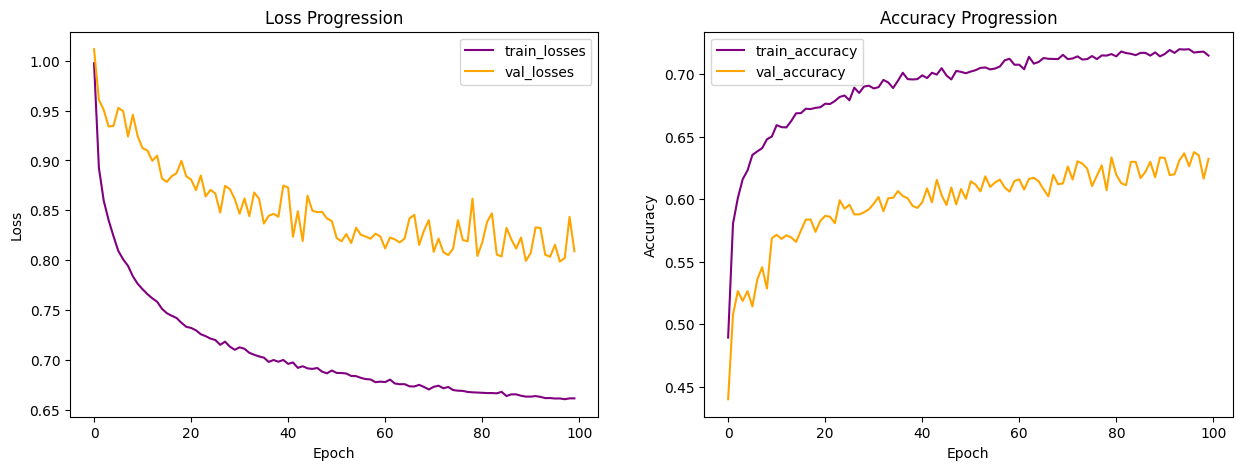

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['all_features'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.6598 - accuracy: 0.7170


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['all_features'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.8090 - accuracy: 0.6322


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.80      0.69      0.74      2758
      comsan       0.81      0.69      0.75      2730
     eaywag1       0.60      0.77      0.68      2748

    accuracy                           0.72      8236
   macro avg       0.74      0.72      0.72      8236
weighted avg       0.74      0.72      0.72      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.83      0.54      0.65      1760
      comsan       0.68      0.61      0.64      1112
     eaywag1       0.50      0.77      0.61      1364

    accuracy                           0.63      4236
   macro avg       0.67      0.64      0.63      4236
weighted avg       0.69      0.63      0.64      4236



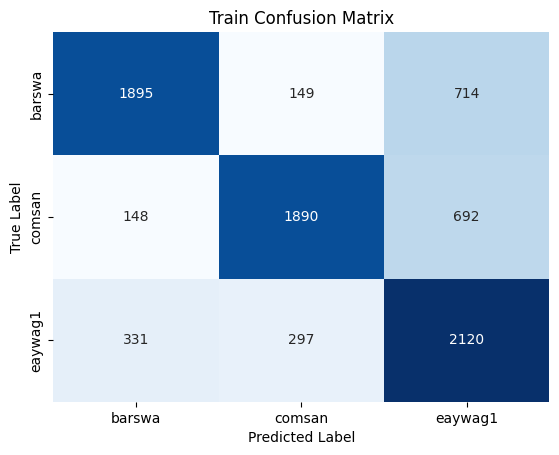

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

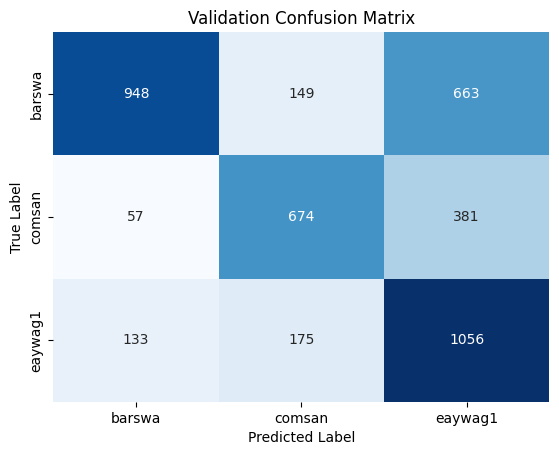

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only MFCC

### create features

In [ ]:
training_features = audio_df['train']['mfcc']

training_features

array([[0.5930482 , 0.5446129 , 0.5541285 , ..., 0.3984707 , 0.5321854 ,
        0.47193125],
       [0.5583726 , 0.6627083 , 0.7213851 , ..., 0.57025504, 0.5074533 ,
        0.59585416],
       [0.47997722, 0.5521823 , 0.4166696 , ..., 0.44832835, 0.4903606 ,
        0.47101495],
       ...,
       [0.48278284, 0.5173334 , 0.47200337, ..., 0.54027134, 0.58604574,
        0.5687983 ],
       [0.66065043, 0.49649855, 0.6818047 , ..., 0.6544724 , 0.32373515,
        0.7463277 ],
       [0.73685646, 0.67966914, 0.6184278 , ..., 0.5166832 , 0.47006226,
        0.49717087]], dtype=float32)

In [ ]:
training_features.shape

(8236, 20)

In [ ]:
validation_features = audio_df['val']['mfcc']

validation_features

array([[0.55223405, 0.5736301 , 0.49003077, ..., 0.3789309 , 0.39995566,
        0.3601121 ],
       [0.6020266 , 0.49644724, 0.37243813, ..., 0.45457885, 0.52638435,
        0.46389726],
       [0.74117553, 0.73505205, 0.44470415, ..., 0.50445026, 0.4472052 ,
        0.45816123],
       ...,
       [0.57345074, 0.5853497 , 0.5723052 , ..., 0.4318886 , 0.4373011 ,
        0.4162933 ],
       [0.52878004, 0.5192951 , 0.5399495 , ..., 0.5091719 , 0.51844364,
        0.5058956 ],
       [0.6139305 , 0.656428  , 0.52483976, ..., 0.52242875, 0.60121006,
        0.4808961 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 20)

### fit the model with training data

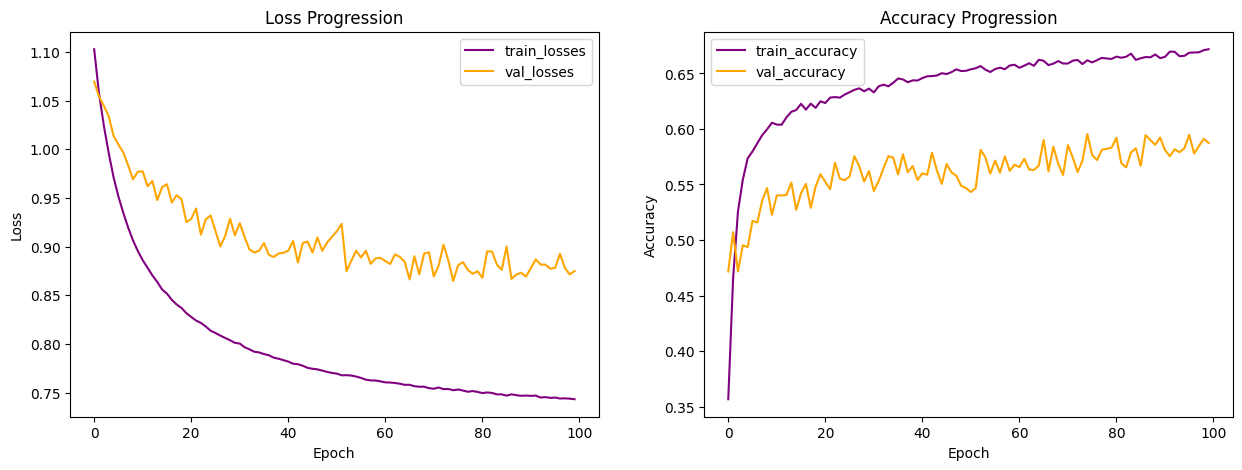

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.7409 - accuracy: 0.6719


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.8749 - accuracy: 0.5873


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.69      0.70      0.70      2758
      comsan       0.75      0.69      0.72      2730
     eaywag1       0.58      0.63      0.60      2748

    accuracy                           0.67      8236
   macro avg       0.68      0.67      0.67      8236
weighted avg       0.68      0.67      0.67      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.71      0.55      0.62      1760
      comsan       0.61      0.63      0.62      1112
     eaywag1       0.47      0.60      0.53      1364

    accuracy                           0.59      4236
   macro avg       0.60      0.59      0.59      4236
weighted avg       0.61      0.59      0.59      4236



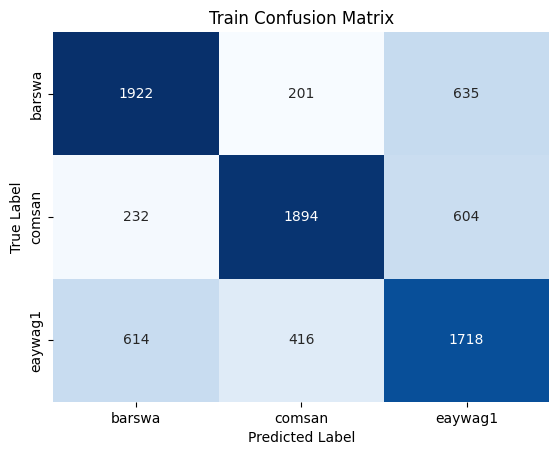

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

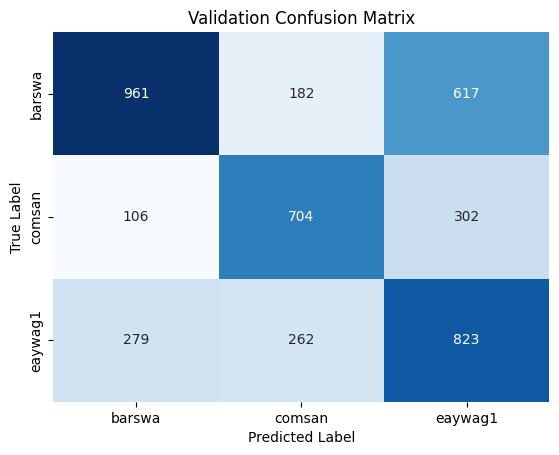

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only chroma

### create features

In [ ]:
training_features = audio_df['train']['chroma']

training_features

array([[0.15238515, 0.2616543 , 0.3085948 , ..., 0.15011597, 0.18795955,
        0.15282477],
       [0.4582031 , 0.64327437, 0.6145165 , ..., 0.17043437, 0.18628296,
        0.28140408],
       [0.63091135, 0.63082606, 0.6613748 , ..., 0.6634692 , 0.66093874,
        0.6478962 ],
       ...,
       [0.6423815 , 0.5947345 , 0.6479578 , ..., 0.76836896, 0.8104712 ,
        0.7284727 ],
       [0.08182476, 0.33484888, 0.58663774, ..., 0.010315  , 0.00742346,
        0.01194611],
       [0.5997566 , 0.74730355, 0.62658477, ..., 0.5125076 , 0.6574448 ,
        0.57781917]], dtype=float32)

In [ ]:
training_features.shape

(8236, 12)

In [ ]:
validation_features = audio_df['val']['chroma']

validation_features

array([[0.6218388 , 0.66416144, 0.56950784, ..., 0.41281357, 0.4456303 ,
        0.42361766],
       [0.36789754, 0.297181  , 0.36397842, ..., 0.36602896, 0.38394532,
        0.37072927],
       [0.7694785 , 0.756398  , 0.70733535, ..., 0.78341424, 0.7592451 ,
        0.7349921 ],
       ...,
       [0.53210884, 0.497953  , 0.5543859 , ..., 0.55328906, 0.4887705 ,
        0.5437372 ],
       [0.7139069 , 0.7349622 , 0.710446  , ..., 0.8068794 , 0.7663285 ,
        0.67505914],
       [0.7223518 , 0.5525446 , 0.47097048, ..., 0.7461877 , 0.7712844 ,
        0.8338788 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 12)

### fit the model with training data

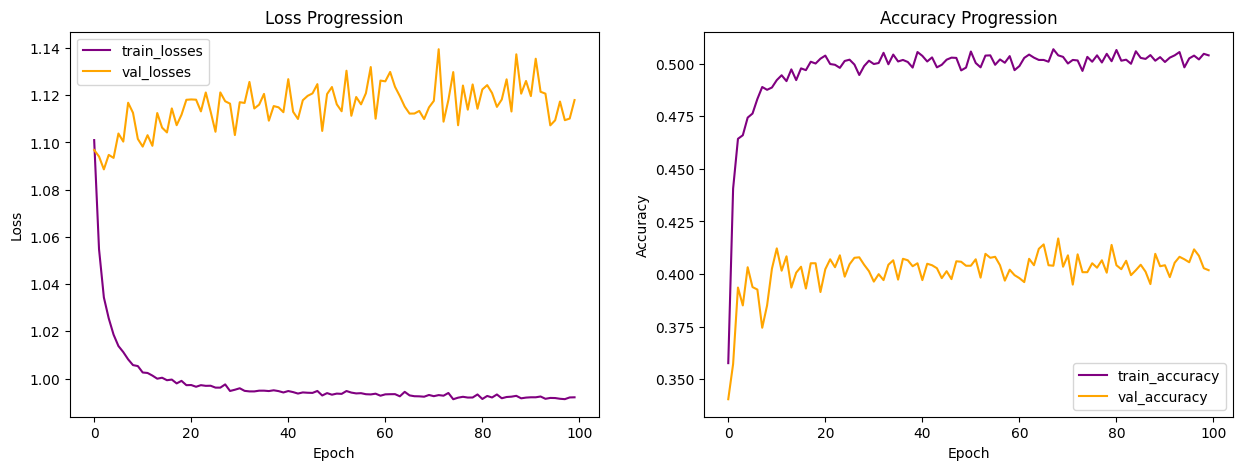

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['chroma'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 1ms/step - loss: 0.9905 - accuracy: 0.4999


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['chroma'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 1.1179 - accuracy: 0.4018


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.50      0.54      0.52      2758
      comsan       0.54      0.64      0.58      2730
     eaywag1       0.44      0.33      0.38      2748

    accuracy                           0.50      8236
   macro avg       0.49      0.50      0.49      8236
weighted avg       0.49      0.50      0.49      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.48      0.43      0.45      1760
      comsan       0.38      0.53      0.44      1112
     eaywag1       0.32      0.26      0.29      1364

    accuracy                           0.40      4236
   macro avg       0.39      0.41      0.39      4236
weighted avg       0.40      0.40      0.40      4236



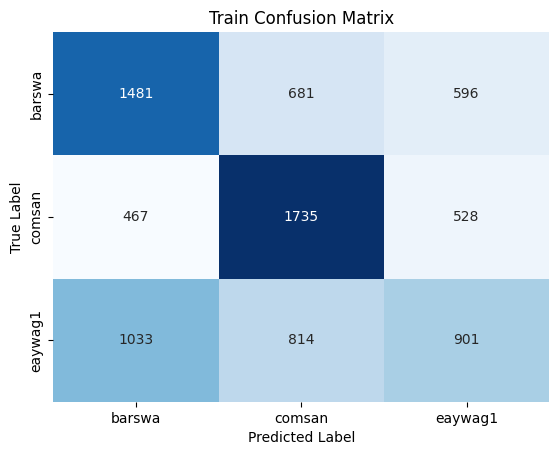

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

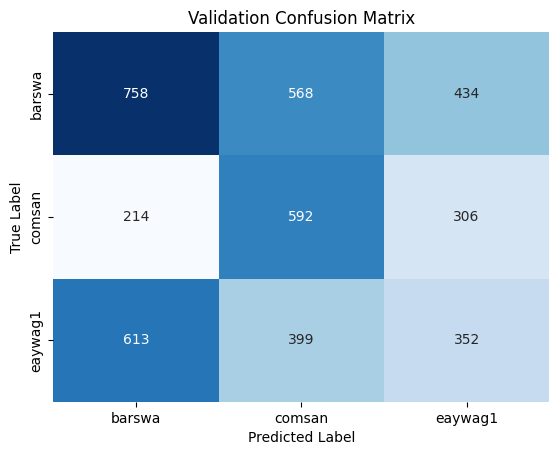

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only RMS & Spectral_Centroid

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=1)

training_features

array([[0.09763344, 0.58330315],
       [0.01607873, 0.39479202],
       [0.00251698, 0.3715388 ],
       ...,
       [0.00209473, 0.494376  ],
       [0.18058556, 0.63887304],
       [0.03411634, 0.31113392]], dtype=float32)

In [ ]:
training_features.shape

(8236, 2)

In [ ]:
validation_features = np.concatenate((audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=1)

validation_features

array([[0.00495675, 0.4199668 ],
       [0.01535587, 0.47640806],
       [0.03380023, 0.21374507],
       ...,
       [0.00851833, 0.44030926],
       [0.00317614, 0.5419082 ],
       [0.01554972, 0.2645438 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 2)

### fit the model with training data

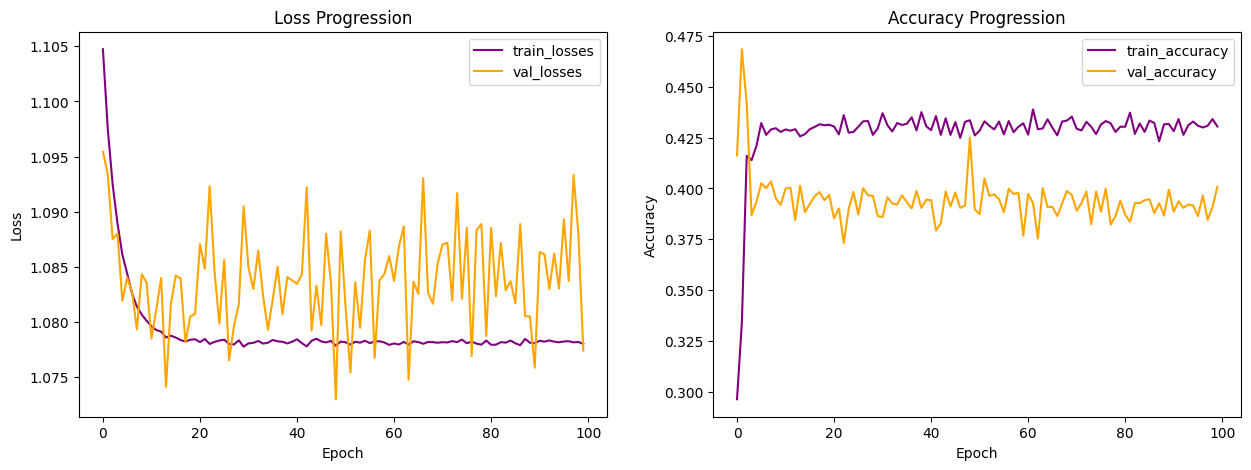

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['rms_spectral_centroid'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 1.0780 - accuracy: 0.4182


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['rms_spectral_centroid'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 1.0774 - accuracy: 0.4008


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.40      0.50      0.45      2758
      comsan       0.46      0.43      0.44      2730
     eaywag1       0.40      0.32      0.36      2748

    accuracy                           0.42      8236
   macro avg       0.42      0.42      0.42      8236
weighted avg       0.42      0.42      0.42      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.54      0.40      0.46      1760
      comsan       0.37      0.58      0.45      1112
     eaywag1       0.30      0.26      0.28      1364

    accuracy                           0.40      4236
   macro avg       0.40      0.41      0.39      4236
weighted avg       0.42      0.40      0.40      4236



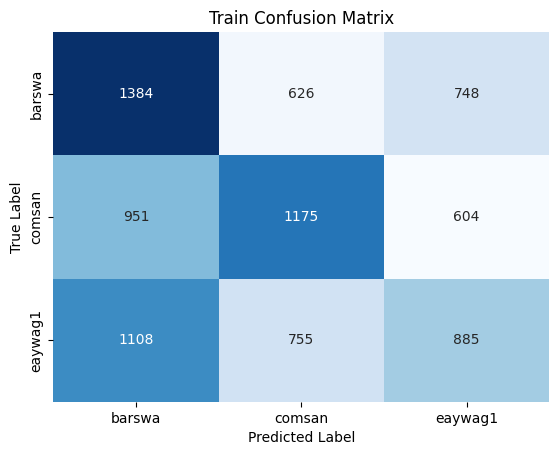

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

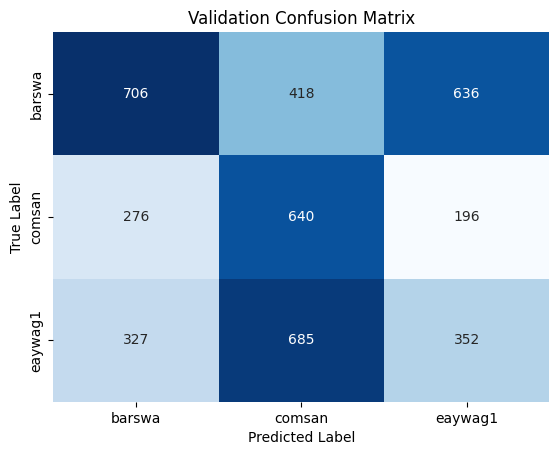

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With only melspectrogram

### create features

In [ ]:
training_features = audio_df['train']['melspectrogram']

training_features

array([[0.53896224, 0.5382145 , 0.54858524, ..., 0.665387  , 0.58348966,
        0.41464233],
       [0.6766458 , 0.6822343 , 0.62790626, ..., 0.5305445 , 0.4098594 ,
        0.38073215],
       [0.4292432 , 0.5409388 , 0.55082095, ..., 0.34840593, 0.3530349 ,
        0.35336396],
       ...,
       [0.40457806, 0.42597717, 0.43862545, ..., 0.38262224, 0.38665038,
        0.38548574],
       [0.63924813, 0.58731204, 0.56138533, ..., 0.8008246 , 0.5783816 ,
        0.5791096 ],
       [0.7643681 , 0.7815945 , 0.75570196, ..., 0.5453557 , 0.5494147 ,
        0.54622793]], dtype=float32)

In [ ]:
training_features.shape

(8236, 20)

In [ ]:
validation_features = audio_df['val']['melspectrogram']

validation_features

array([[0.51499027, 0.5565996 , 0.56469846, ..., 0.43435732, 0.43031004,
        0.41939414],
       [0.43145022, 0.5246458 , 0.54172117, ..., 0.5742578 , 0.50332046,
        0.39846554],
       [0.7467929 , 0.7681602 , 0.7457926 , ..., 0.46886736, 0.4203202 ,
        0.39482322],
       ...,
       [0.56870776, 0.6038414 , 0.58420295, ..., 0.45841202, 0.4490561 ,
        0.44114608],
       [0.476503  , 0.45110127, 0.44740814, ..., 0.43825915, 0.44199085,
        0.44542962],
       [0.6879635 , 0.62703204, 0.60789555, ..., 0.4054285 , 0.4054131 ,
        0.39360863]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 20)

### fit the model with training data

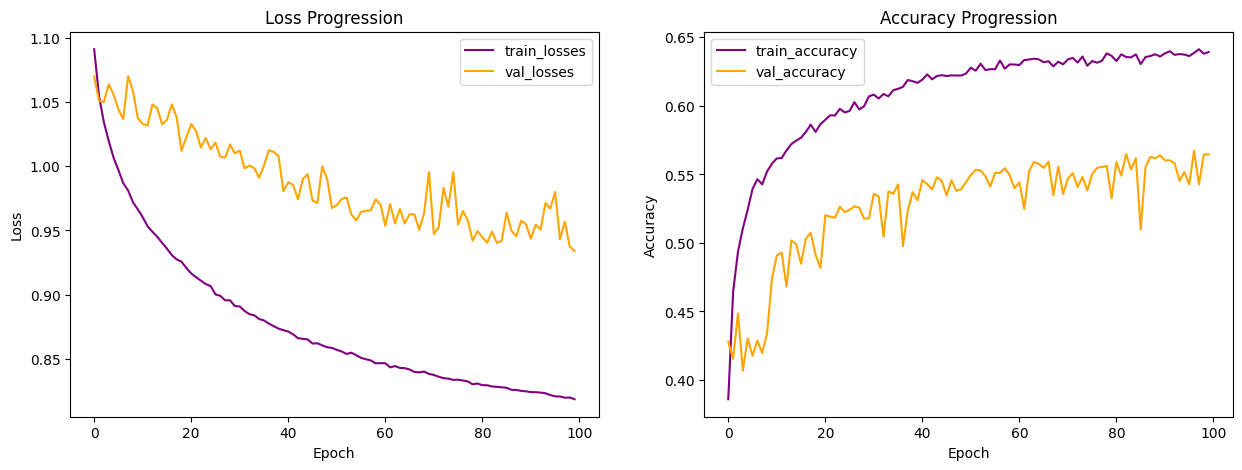

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.8178 - accuracy: 0.6405


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.9340 - accuracy: 0.5647


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.65      0.67      0.66      2758
      comsan       0.78      0.65      0.71      2730
     eaywag1       0.53      0.60      0.57      2748

    accuracy                           0.64      8236
   macro avg       0.65      0.64      0.64      8236
weighted avg       0.65      0.64      0.64      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.65      0.53      0.58      1760
      comsan       0.67      0.59      0.62      1112
     eaywag1       0.44      0.59      0.51      1364

    accuracy                           0.56      4236
   macro avg       0.59      0.57      0.57      4236
weighted avg       0.59      0.56      0.57      4236



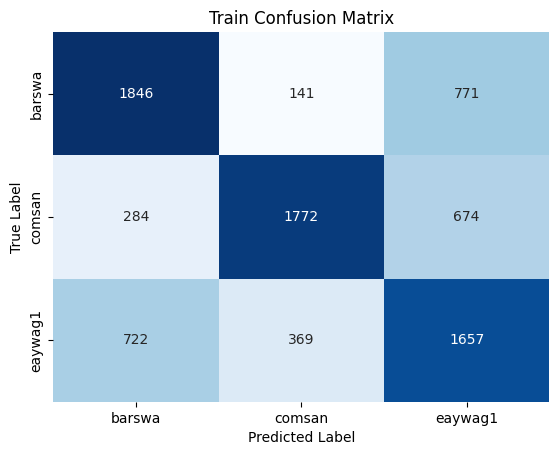

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

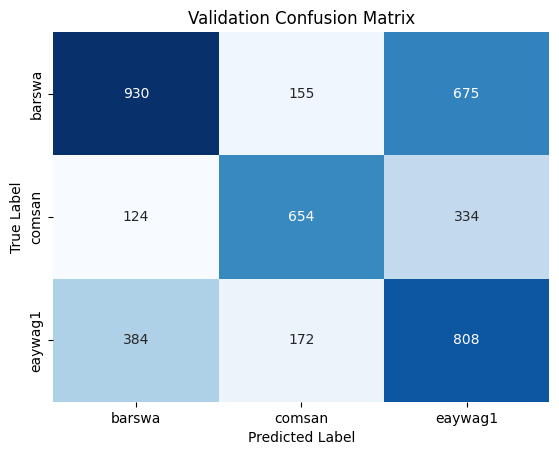

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.59304821, 0.54461288, 0.55412853, ..., 0.        , 1.        ,
        0.        ],
       [0.55837262, 0.66270828, 0.72138512, ..., 0.        , 1.        ,
        0.        ],
       [0.47997722, 0.55218232, 0.41666961, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48278284, 0.51733339, 0.47200337, ..., 0.        , 1.        ,
        0.        ],
       [0.66065043, 0.49649855, 0.68180472, ..., 0.        , 1.        ,
        0.        ],
       [0.73685646, 0.67966914, 0.61842781, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 25)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.55223405, 0.57363009, 0.49003077, ..., 0.        , 1.        ,
        0.        ],
       [0.60202658, 0.49644724, 0.37243813, ..., 0.        , 1.        ,
        0.        ],
       [0.74117553, 0.73505205, 0.44470415, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.57345074, 0.58534968, 0.5723052 , ..., 0.        , 1.        ,
        0.        ],
       [0.52878004, 0.5192951 , 0.53994948, ..., 0.        , 0.        ,
        1.        ],
       [0.61393052, 0.65642798, 0.52483976, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 25)

### fit the model with training data

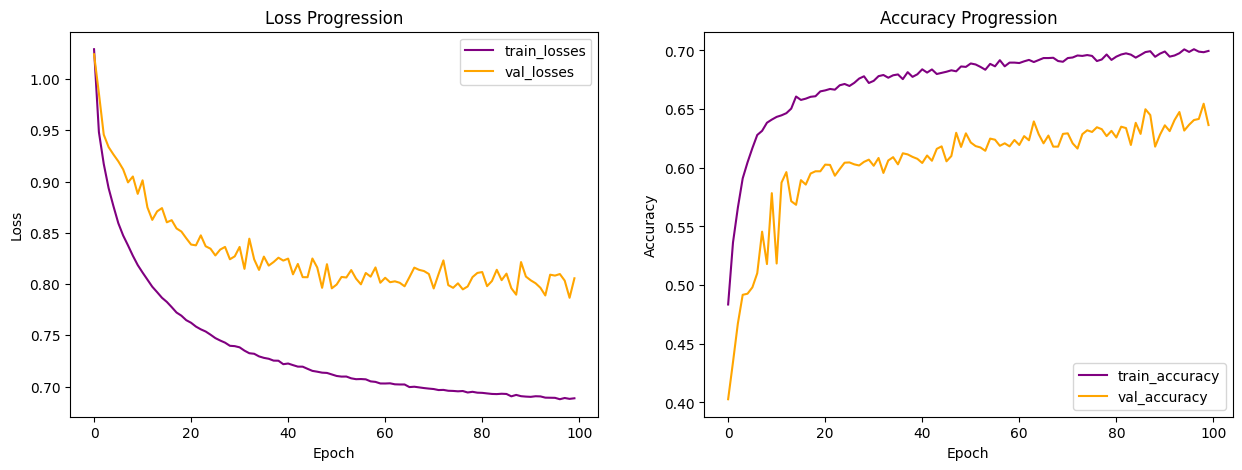

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_continents'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 1s 2ms/step - loss: 0.6852 - accuracy: 0.7020


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_continents'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.8057 - accuracy: 0.6364


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.79      0.65      0.72      2758
      comsan       0.75      0.73      0.74      2730
     eaywag1       0.60      0.72      0.65      2748

    accuracy                           0.70      8236
   macro avg       0.71      0.70      0.70      8236
weighted avg       0.71      0.70      0.70      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.83      0.55      0.66      1760
      comsan       0.62      0.69      0.66      1112
     eaywag1       0.52      0.71      0.60      1364

    accuracy                           0.64      4236
   macro avg       0.66      0.65      0.64      4236
weighted avg       0.68      0.64      0.64      4236



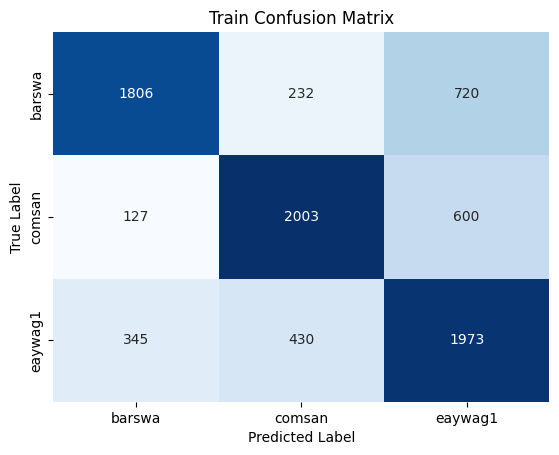

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

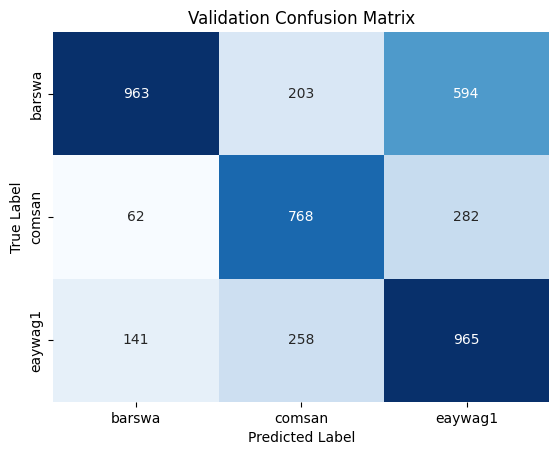

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & chroma

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'],), axis=1)

training_features

array([[0.5930482 , 0.5446129 , 0.5541285 , ..., 0.15011597, 0.18795955,
        0.15282477],
       [0.5583726 , 0.6627083 , 0.7213851 , ..., 0.17043437, 0.18628296,
        0.28140408],
       [0.47997722, 0.5521823 , 0.4166696 , ..., 0.6634692 , 0.66093874,
        0.6478962 ],
       ...,
       [0.48278284, 0.5173334 , 0.47200337, ..., 0.76836896, 0.8104712 ,
        0.7284727 ],
       [0.66065043, 0.49649855, 0.6818047 , ..., 0.010315  , 0.00742346,
        0.01194611],
       [0.73685646, 0.67966914, 0.6184278 , ..., 0.5125076 , 0.6574448 ,
        0.57781917]], dtype=float32)

In [ ]:
training_features.shape

(8236, 32)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma']), axis=1)

validation_features

array([[0.55223405, 0.5736301 , 0.49003077, ..., 0.41281357, 0.4456303 ,
        0.42361766],
       [0.6020266 , 0.49644724, 0.37243813, ..., 0.36602896, 0.38394532,
        0.37072927],
       [0.74117553, 0.73505205, 0.44470415, ..., 0.78341424, 0.7592451 ,
        0.7349921 ],
       ...,
       [0.57345074, 0.5853497 , 0.5723052 , ..., 0.55328906, 0.4887705 ,
        0.5437372 ],
       [0.52878004, 0.5192951 , 0.5399495 , ..., 0.8068794 , 0.7663285 ,
        0.67505914],
       [0.6139305 , 0.656428  , 0.52483976, ..., 0.7461877 , 0.7712844 ,
        0.8338788 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 32)

### fit the model with training data

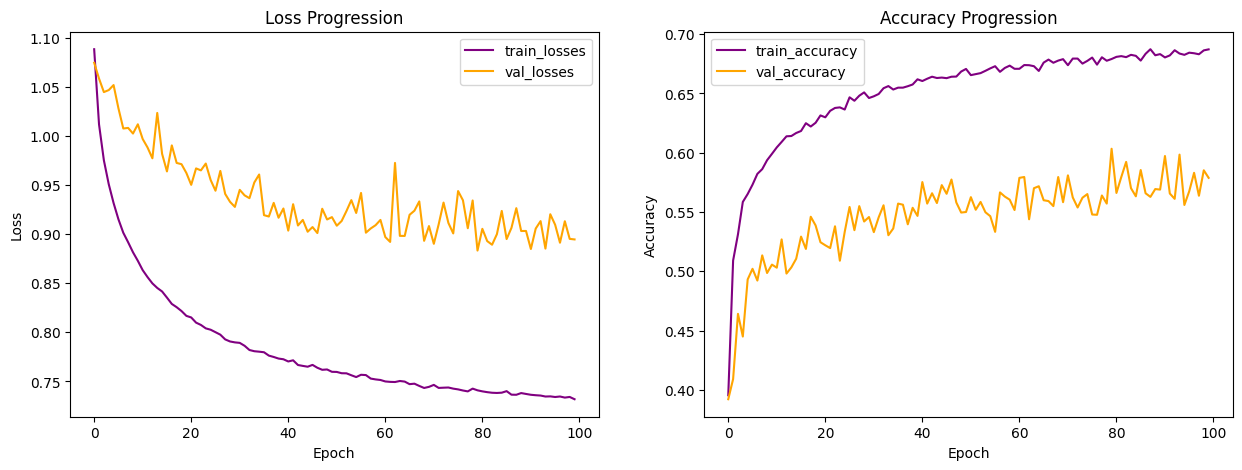

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_chroma'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.7300 - accuracy: 0.6870


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_chroma'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.8946 - accuracy: 0.5788


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.72      0.68      0.70      2758
      comsan       0.77      0.70      0.73      2730
     eaywag1       0.60      0.68      0.64      2748

    accuracy                           0.69      8236
   macro avg       0.69      0.69      0.69      8236
weighted avg       0.69      0.69      0.69      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.73      0.50      0.60      1760
      comsan       0.62      0.61      0.61      1112
     eaywag1       0.46      0.65      0.54      1364

    accuracy                           0.58      4236
   macro avg       0.60      0.59      0.58      4236
weighted avg       0.62      0.58      0.58      4236



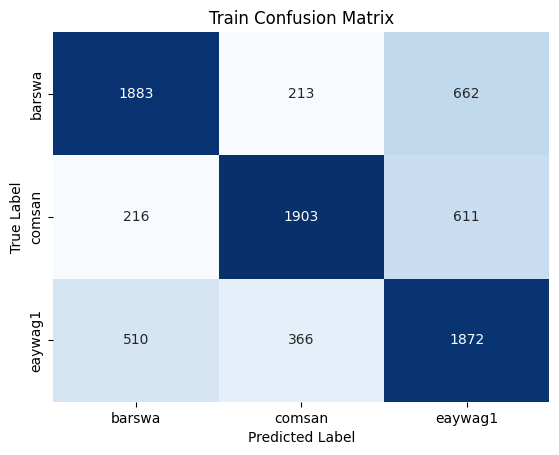

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

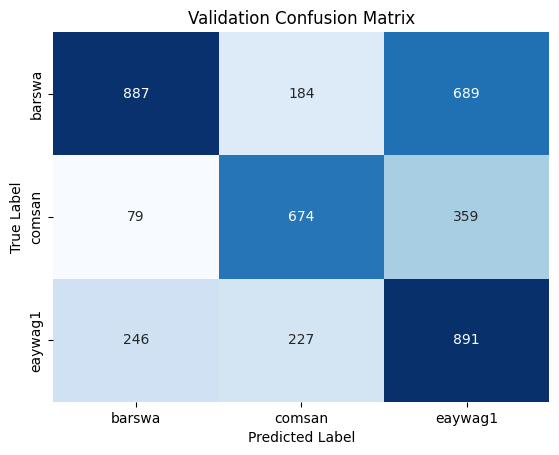

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & chroma & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['chroma'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.59304821, 0.54461288, 0.55412853, ..., 0.        , 1.        ,
        0.        ],
       [0.55837262, 0.66270828, 0.72138512, ..., 0.        , 1.        ,
        0.        ],
       [0.47997722, 0.55218232, 0.41666961, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48278284, 0.51733339, 0.47200337, ..., 0.        , 1.        ,
        0.        ],
       [0.66065043, 0.49649855, 0.68180472, ..., 0.        , 1.        ,
        0.        ],
       [0.73685646, 0.67966914, 0.61842781, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 37)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['chroma'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.55223405, 0.57363009, 0.49003077, ..., 0.        , 1.        ,
        0.        ],
       [0.60202658, 0.49644724, 0.37243813, ..., 0.        , 1.        ,
        0.        ],
       [0.74117553, 0.73505205, 0.44470415, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.57345074, 0.58534968, 0.5723052 , ..., 0.        , 1.        ,
        0.        ],
       [0.52878004, 0.5192951 , 0.53994948, ..., 0.        , 0.        ,
        1.        ],
       [0.61393052, 0.65642798, 0.52483976, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 37)

### fit the model with training data

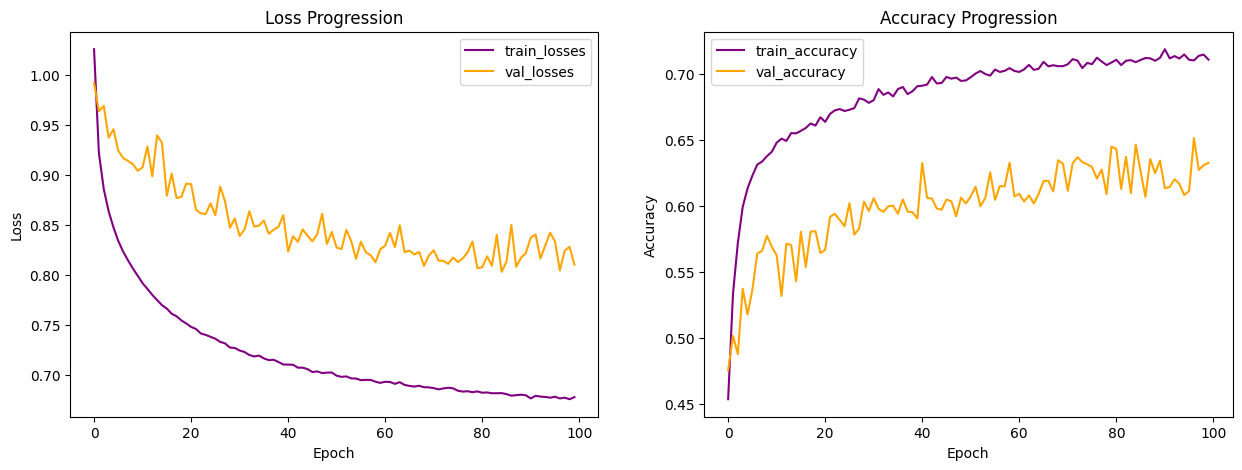

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_chroma_continents'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.6723 - accuracy: 0.7169


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_chroma_continents'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.8102 - accuracy: 0.6327


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.78      0.70      0.74      2758
      comsan       0.77      0.73      0.75      2730
     eaywag1       0.62      0.72      0.67      2748

    accuracy                           0.72      8236
   macro avg       0.73      0.72      0.72      8236
weighted avg       0.73      0.72      0.72      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.82      0.57      0.67      1760
      comsan       0.62      0.65      0.63      1112
     eaywag1       0.52      0.71      0.60      1364

    accuracy                           0.63      4236
   macro avg       0.65      0.64      0.63      4236
weighted avg       0.67      0.63      0.64      4236



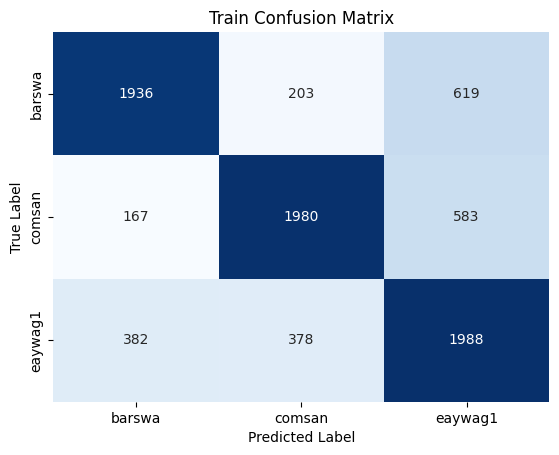

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

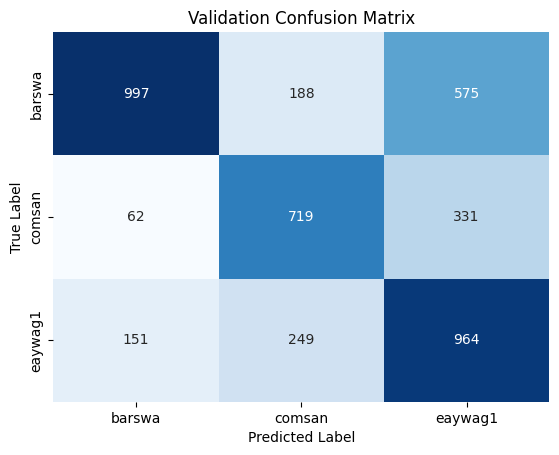

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & spectral_centroid

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=1)

training_features

array([[0.5930482 , 0.5446129 , 0.5541285 , ..., 0.47193125, 0.09763344,
        0.58330315],
       [0.5583726 , 0.6627083 , 0.7213851 , ..., 0.59585416, 0.01607873,
        0.39479202],
       [0.47997722, 0.5521823 , 0.4166696 , ..., 0.47101495, 0.00251698,
        0.3715388 ],
       ...,
       [0.48278284, 0.5173334 , 0.47200337, ..., 0.5687983 , 0.00209473,
        0.494376  ],
       [0.66065043, 0.49649855, 0.6818047 , ..., 0.7463277 , 0.18058556,
        0.63887304],
       [0.73685646, 0.67966914, 0.6184278 , ..., 0.49717087, 0.03411634,
        0.31113392]], dtype=float32)

In [ ]:
training_features.shape

(8236, 22)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=1)

validation_features

array([[0.55223405, 0.5736301 , 0.49003077, ..., 0.3601121 , 0.00495675,
        0.4199668 ],
       [0.6020266 , 0.49644724, 0.37243813, ..., 0.46389726, 0.01535587,
        0.47640806],
       [0.74117553, 0.73505205, 0.44470415, ..., 0.45816123, 0.03380023,
        0.21374507],
       ...,
       [0.57345074, 0.5853497 , 0.5723052 , ..., 0.4162933 , 0.00851833,
        0.44030926],
       [0.52878004, 0.5192951 , 0.5399495 , ..., 0.5058956 , 0.00317614,
        0.5419082 ],
       [0.6139305 , 0.656428  , 0.52483976, ..., 0.4808961 , 0.01554972,
        0.2645438 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 22)

### fit the model with training data

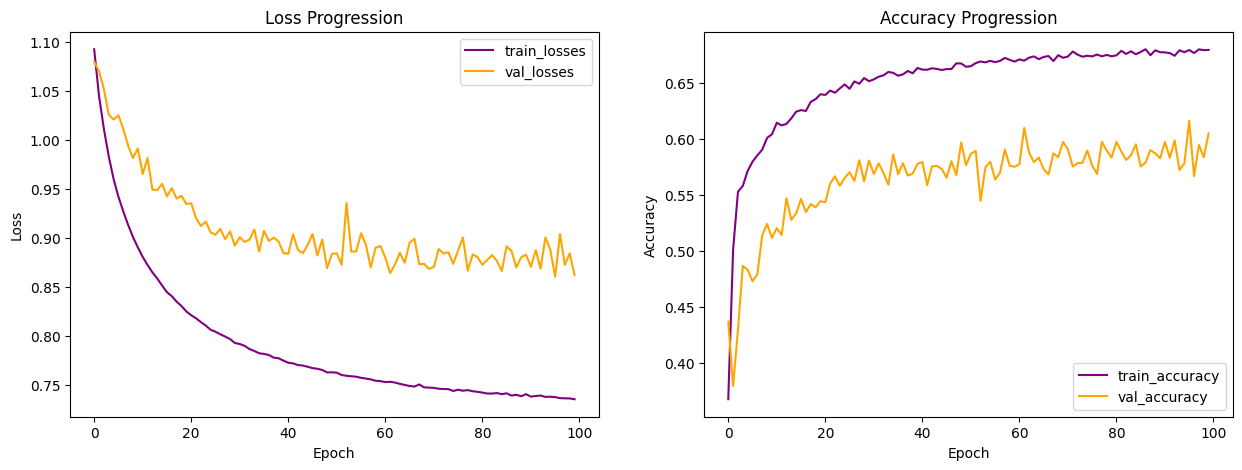

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_rms_spectral_centroid'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.7378 - accuracy: 0.6815


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_rms_spectral_centroid'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.8624 - accuracy: 0.6048


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.67      0.77      0.72      2758
      comsan       0.78      0.68      0.73      2730
     eaywag1       0.61      0.60      0.60      2748

    accuracy                           0.68      8236
   macro avg       0.69      0.68      0.68      8236
weighted avg       0.69      0.68      0.68      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.68      0.64      0.66      1760
      comsan       0.65      0.61      0.63      1112
     eaywag1       0.49      0.56      0.52      1364

    accuracy                           0.60      4236
   macro avg       0.61      0.60      0.60      4236
weighted avg       0.61      0.60      0.61      4236



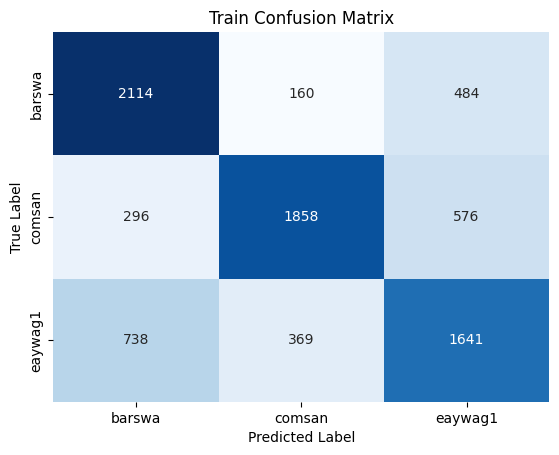

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

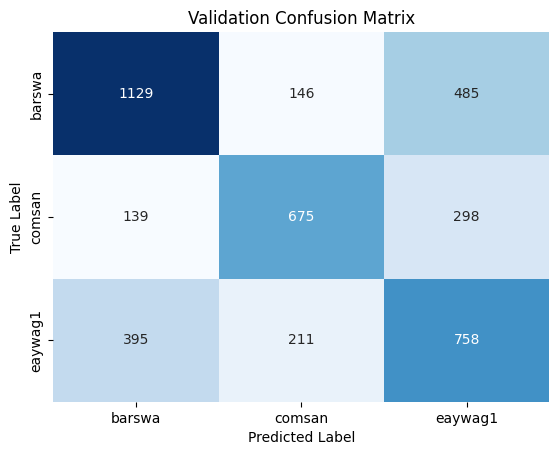

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & rms & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['rms'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.59304821, 0.54461288, 0.55412853, ..., 0.        , 1.        ,
        0.        ],
       [0.55837262, 0.66270828, 0.72138512, ..., 0.        , 1.        ,
        0.        ],
       [0.47997722, 0.55218232, 0.41666961, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48278284, 0.51733339, 0.47200337, ..., 0.        , 1.        ,
        0.        ],
       [0.66065043, 0.49649855, 0.68180472, ..., 0.        , 1.        ,
        0.        ],
       [0.73685646, 0.67966914, 0.61842781, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['rms'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.55223405, 0.57363009, 0.49003077, ..., 0.        , 1.        ,
        0.        ],
       [0.60202658, 0.49644724, 0.37243813, ..., 0.        , 1.        ,
        0.        ],
       [0.74117553, 0.73505205, 0.44470415, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.57345074, 0.58534968, 0.5723052 , ..., 0.        , 1.        ,
        0.        ],
       [0.52878004, 0.5192951 , 0.53994948, ..., 0.        , 0.        ,
        1.        ],
       [0.61393052, 0.65642798, 0.52483976, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 26)

### fit the model with training data

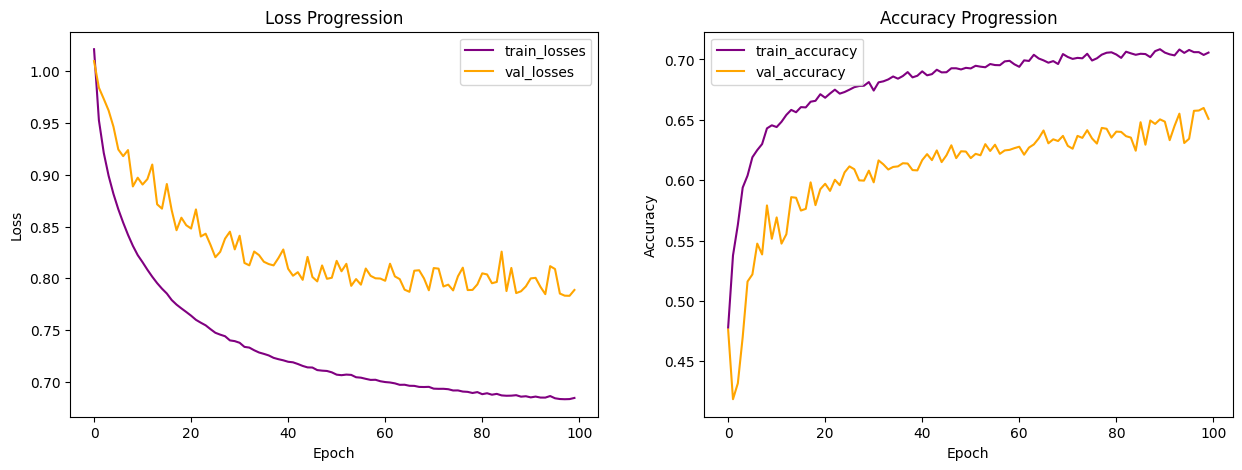

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_rms_continents'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.7099


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_rms_continents'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.7888 - accuracy: 0.6508


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.77      0.72      0.74      2758
      comsan       0.81      0.68      0.74      2730
     eaywag1       0.60      0.74      0.66      2748

    accuracy                           0.71      8236
   macro avg       0.72      0.71      0.71      8236
weighted avg       0.72      0.71      0.71      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.80      0.60      0.69      1760
      comsan       0.70      0.62      0.65      1112
     eaywag1       0.52      0.74      0.61      1364

    accuracy                           0.65      4236
   macro avg       0.68      0.65      0.65      4236
weighted avg       0.69      0.65      0.66      4236



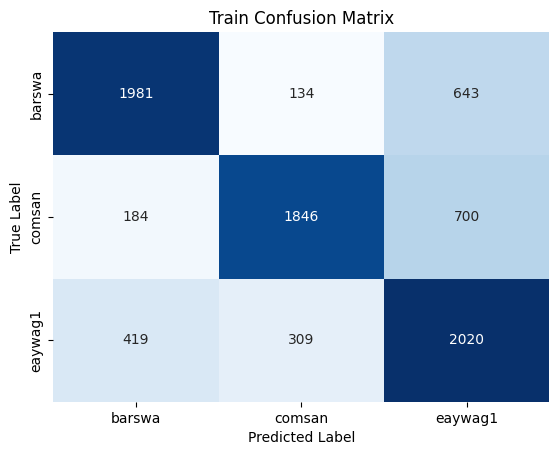

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

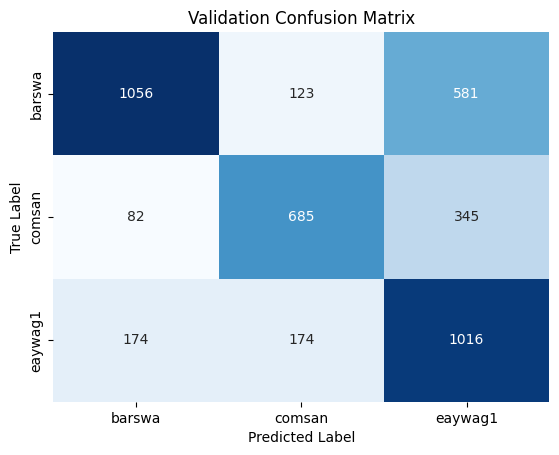

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With mfcc & spectral_centroid & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['mfcc'], audio_df['train']['spectral_centroid'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.59304821, 0.54461288, 0.55412853, ..., 0.        , 1.        ,
        0.        ],
       [0.55837262, 0.66270828, 0.72138512, ..., 0.        , 1.        ,
        0.        ],
       [0.47997722, 0.55218232, 0.41666961, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.48278284, 0.51733339, 0.47200337, ..., 0.        , 1.        ,
        0.        ],
       [0.66065043, 0.49649855, 0.68180472, ..., 0.        , 1.        ,
        0.        ],
       [0.73685646, 0.67966914, 0.61842781, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['mfcc'], audio_df['val']['spectral_centroid'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.55223405, 0.57363009, 0.49003077, ..., 0.        , 1.        ,
        0.        ],
       [0.60202658, 0.49644724, 0.37243813, ..., 0.        , 1.        ,
        0.        ],
       [0.74117553, 0.73505205, 0.44470415, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.57345074, 0.58534968, 0.5723052 , ..., 0.        , 1.        ,
        0.        ],
       [0.52878004, 0.5192951 , 0.53994948, ..., 0.        , 0.        ,
        1.        ],
       [0.61393052, 0.65642798, 0.52483976, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 26)

### fit the model with training data

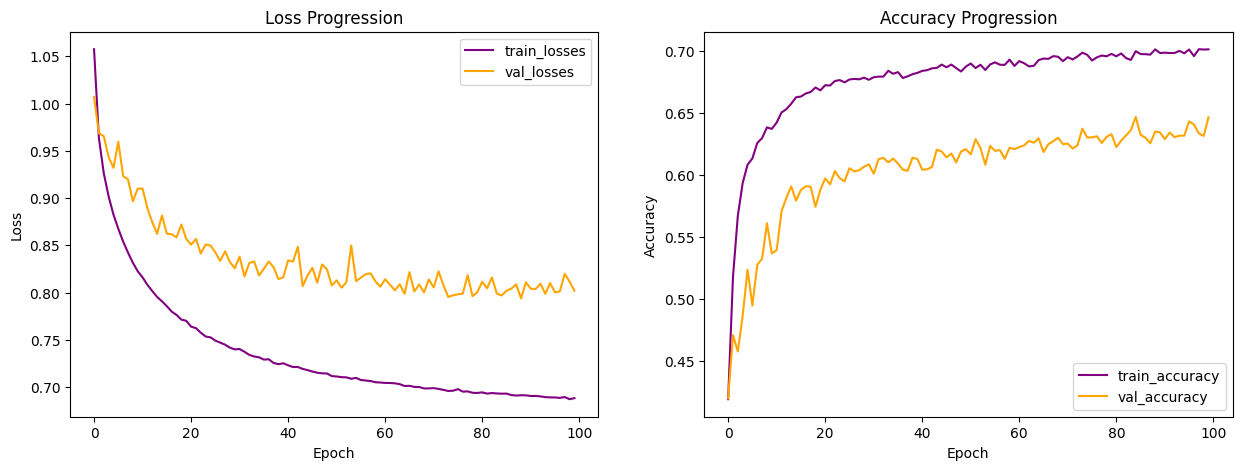

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['mfcc_spectral_centroid_continents'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.7050


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['mfcc_spectral_centroid_continents'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.8019 - accuracy: 0.6466


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.75      0.71      0.73      2758
      comsan       0.73      0.77      0.75      2730
     eaywag1       0.64      0.64      0.64      2748

    accuracy                           0.70      8236
   macro avg       0.71      0.71      0.70      8236
weighted avg       0.71      0.70      0.70      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.78      0.61      0.68      1760
      comsan       0.60      0.73      0.66      1112
     eaywag1       0.56      0.63      0.59      1364

    accuracy                           0.65      4236
   macro avg       0.65      0.66      0.65      4236
weighted avg       0.66      0.65      0.65      4236



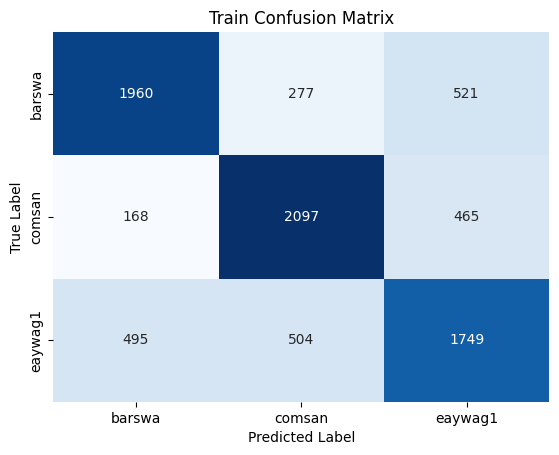

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

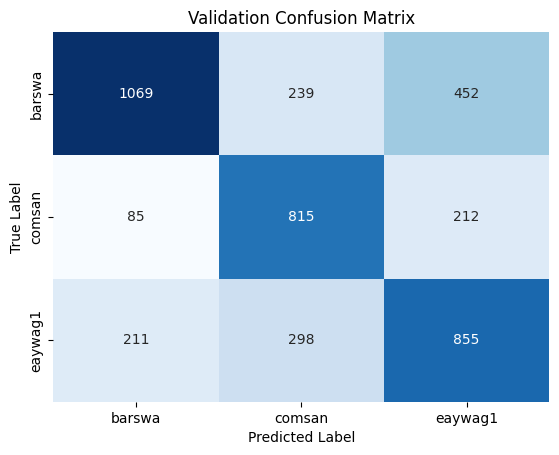

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & chroma

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['chroma']), axis=1)

training_features

array([[0.53896224, 0.5382145 , 0.54858524, ..., 0.15011597, 0.18795955,
        0.15282477],
       [0.6766458 , 0.6822343 , 0.62790626, ..., 0.17043437, 0.18628296,
        0.28140408],
       [0.4292432 , 0.5409388 , 0.55082095, ..., 0.6634692 , 0.66093874,
        0.6478962 ],
       ...,
       [0.40457806, 0.42597717, 0.43862545, ..., 0.76836896, 0.8104712 ,
        0.7284727 ],
       [0.63924813, 0.58731204, 0.56138533, ..., 0.010315  , 0.00742346,
        0.01194611],
       [0.7643681 , 0.7815945 , 0.75570196, ..., 0.5125076 , 0.6574448 ,
        0.57781917]], dtype=float32)

In [ ]:
training_features.shape

(8236, 32)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['chroma']), axis=1)

validation_features

array([[0.51499027, 0.5565996 , 0.56469846, ..., 0.41281357, 0.4456303 ,
        0.42361766],
       [0.43145022, 0.5246458 , 0.54172117, ..., 0.36602896, 0.38394532,
        0.37072927],
       [0.7467929 , 0.7681602 , 0.7457926 , ..., 0.78341424, 0.7592451 ,
        0.7349921 ],
       ...,
       [0.56870776, 0.6038414 , 0.58420295, ..., 0.55328906, 0.4887705 ,
        0.5437372 ],
       [0.476503  , 0.45110127, 0.44740814, ..., 0.8068794 , 0.7663285 ,
        0.67505914],
       [0.6879635 , 0.62703204, 0.60789555, ..., 0.7461877 , 0.7712844 ,
        0.8338788 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 32)

### fit the model with training data

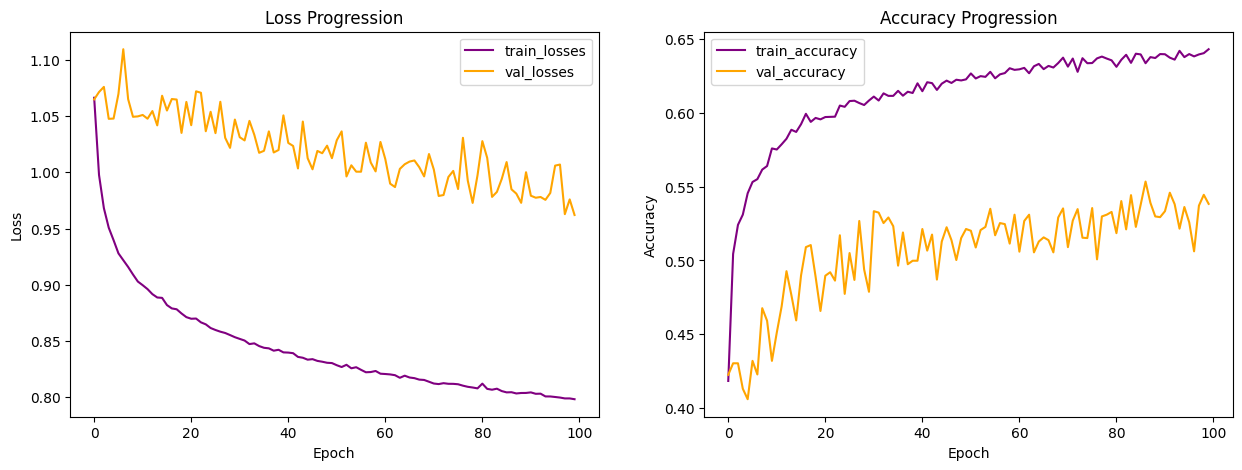

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.8046 - accuracy: 0.6351


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.9620 - accuracy: 0.5382


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.60      0.71      0.65      2758
      comsan       0.74      0.67      0.70      2730
     eaywag1       0.58      0.52      0.55      2748

    accuracy                           0.64      8236
   macro avg       0.64      0.64      0.63      8236
weighted avg       0.64      0.64      0.63      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.58      0.58      0.58      1760
      comsan       0.61      0.57      0.59      1112
     eaywag1       0.43      0.46      0.44      1364

    accuracy                           0.54      4236
   macro avg       0.54      0.54      0.54      4236
weighted avg       0.54      0.54      0.54      4236



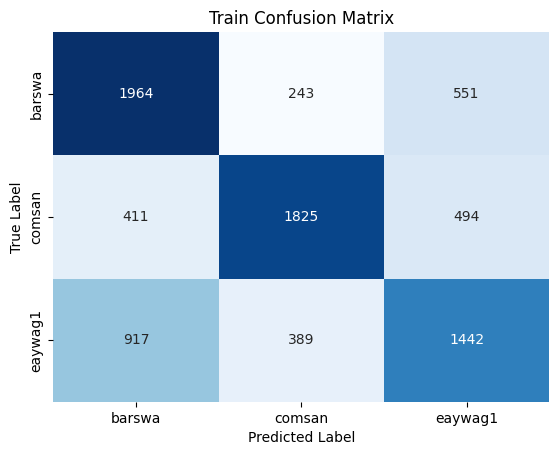

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

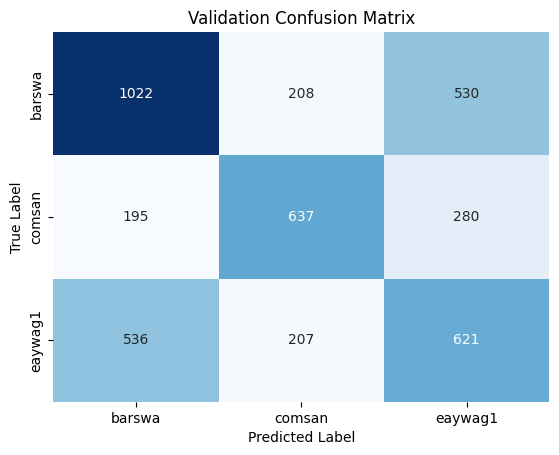

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & chroma & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['chroma'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.53896224, 0.5382145 , 0.54858524, ..., 0.        , 1.        ,
        0.        ],
       [0.67664582, 0.68223429, 0.62790626, ..., 0.        , 1.        ,
        0.        ],
       [0.42924321, 0.54093879, 0.55082095, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.40457806, 0.42597717, 0.43862545, ..., 0.        , 1.        ,
        0.        ],
       [0.63924813, 0.58731204, 0.56138533, ..., 0.        , 1.        ,
        0.        ],
       [0.76436812, 0.78159451, 0.75570196, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 37)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['chroma'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.51499027, 0.55659962, 0.56469846, ..., 0.        , 1.        ,
        0.        ],
       [0.43145022, 0.52464581, 0.54172117, ..., 0.        , 1.        ,
        0.        ],
       [0.74679291, 0.76816022, 0.74579263, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.56870776, 0.60384142, 0.58420295, ..., 0.        , 1.        ,
        0.        ],
       [0.47650301, 0.45110127, 0.44740814, ..., 0.        , 0.        ,
        1.        ],
       [0.68796349, 0.62703204, 0.60789555, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 37)

### fit the model with training data

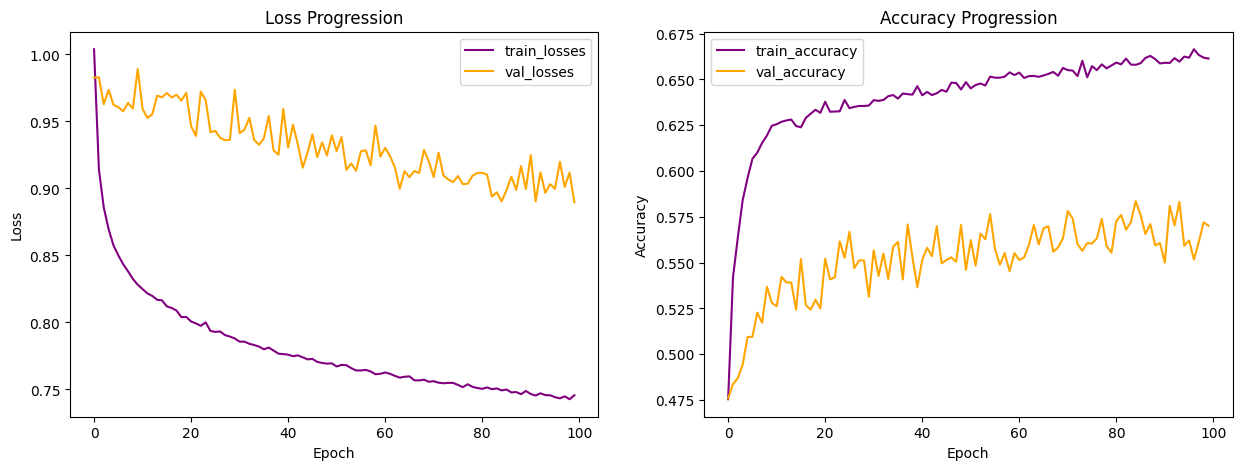

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_chroma_continents'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.7386 - accuracy: 0.6638


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_chroma_continents'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.8897 - accuracy: 0.5701


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.72      0.62      0.67      2758
      comsan       0.71      0.73      0.72      2730
     eaywag1       0.58      0.64      0.60      2748

    accuracy                           0.66      8236
   macro avg       0.67      0.66      0.66      8236
weighted avg       0.67      0.66      0.66      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.76      0.51      0.61      1760
      comsan       0.54      0.65      0.59      1112
     eaywag1       0.46      0.58      0.52      1364

    accuracy                           0.57      4236
   macro avg       0.59      0.58      0.57      4236
weighted avg       0.61      0.57      0.57      4236



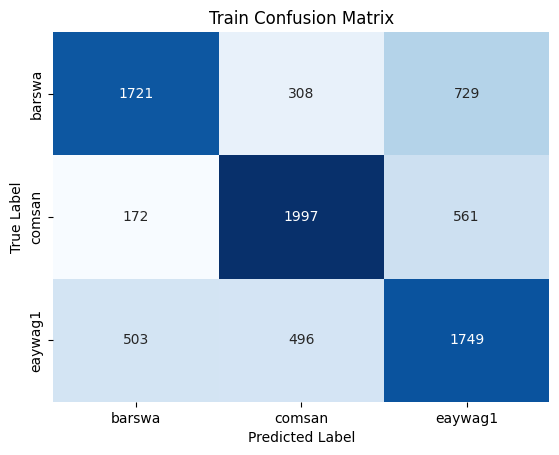

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

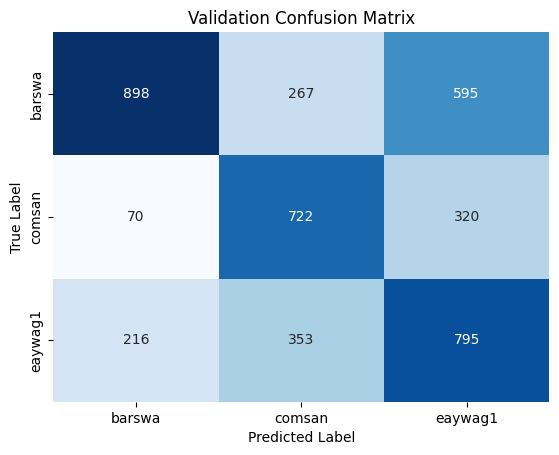

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & rms & spectral_centroid

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['rms'], audio_df['train']['spectral_centroid']), axis=1)

training_features

array([[0.53896224, 0.5382145 , 0.54858524, ..., 0.41464233, 0.09763344,
        0.58330315],
       [0.6766458 , 0.6822343 , 0.62790626, ..., 0.38073215, 0.01607873,
        0.39479202],
       [0.4292432 , 0.5409388 , 0.55082095, ..., 0.35336396, 0.00251698,
        0.3715388 ],
       ...,
       [0.40457806, 0.42597717, 0.43862545, ..., 0.38548574, 0.00209473,
        0.494376  ],
       [0.63924813, 0.58731204, 0.56138533, ..., 0.5791096 , 0.18058556,
        0.63887304],
       [0.7643681 , 0.7815945 , 0.75570196, ..., 0.54622793, 0.03411634,
        0.31113392]], dtype=float32)

In [ ]:
training_features.shape

(8236, 22)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['rms'], audio_df['val']['spectral_centroid']), axis=1)

validation_features

array([[0.51499027, 0.5565996 , 0.56469846, ..., 0.41939414, 0.00495675,
        0.4199668 ],
       [0.43145022, 0.5246458 , 0.54172117, ..., 0.39846554, 0.01535587,
        0.47640806],
       [0.7467929 , 0.7681602 , 0.7457926 , ..., 0.39482322, 0.03380023,
        0.21374507],
       ...,
       [0.56870776, 0.6038414 , 0.58420295, ..., 0.44114608, 0.00851833,
        0.44030926],
       [0.476503  , 0.45110127, 0.44740814, ..., 0.44542962, 0.00317614,
        0.5419082 ],
       [0.6879635 , 0.62703204, 0.60789555, ..., 0.39360863, 0.01554972,
        0.2645438 ]], dtype=float32)

In [ ]:
validation_features.shape

(4236, 22)

### fit the model with training data

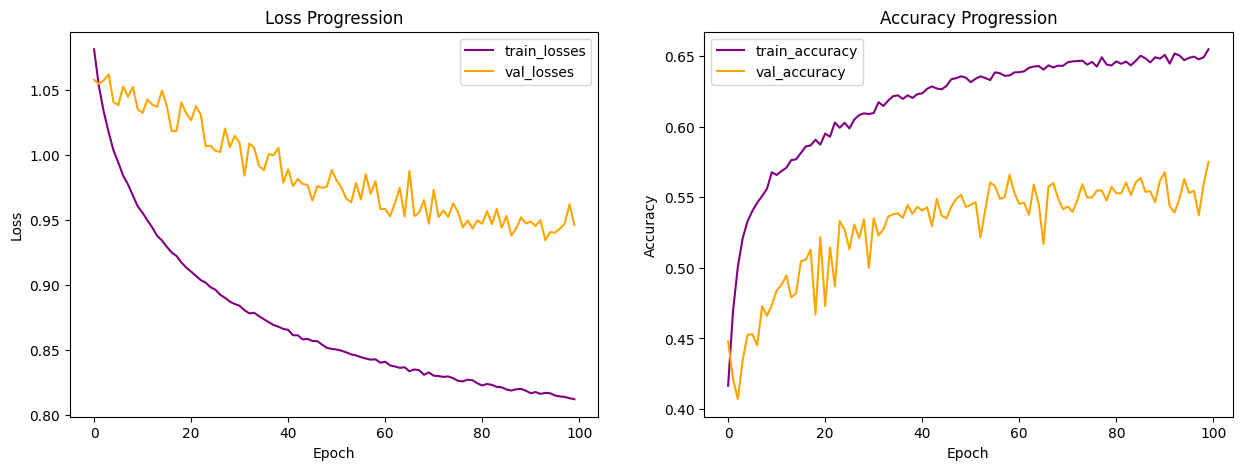

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_rms_spectral_centroid'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 1s 2ms/step - loss: 0.8151 - accuracy: 0.6519


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_rms_spectral_centroid'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 2ms/step - loss: 0.9458 - accuracy: 0.5751


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.71      0.63      0.67      2758
      comsan       0.82      0.59      0.69      2730
     eaywag1       0.53      0.73      0.61      2748

    accuracy                           0.65      8236
   macro avg       0.69      0.65      0.66      8236
weighted avg       0.68      0.65      0.66      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.71      0.49      0.58      1760
      comsan       0.72      0.54      0.62      1112
     eaywag1       0.45      0.71      0.55      1364

    accuracy                           0.58      4236
   macro avg       0.62      0.58      0.58      4236
weighted avg       0.63      0.58      0.58      4236



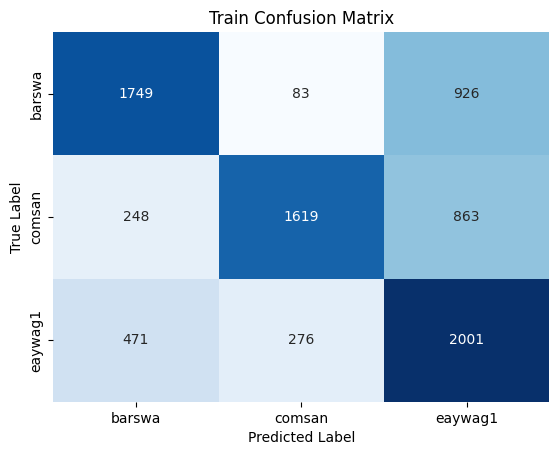

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

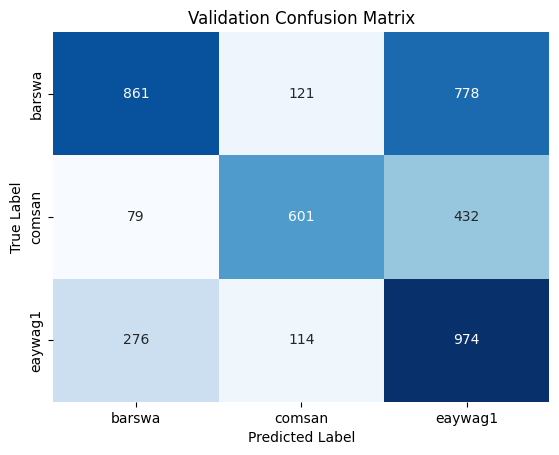

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & rms & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['rms'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.53896224, 0.5382145 , 0.54858524, ..., 0.        , 1.        ,
        0.        ],
       [0.67664582, 0.68223429, 0.62790626, ..., 0.        , 1.        ,
        0.        ],
       [0.42924321, 0.54093879, 0.55082095, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.40457806, 0.42597717, 0.43862545, ..., 0.        , 1.        ,
        0.        ],
       [0.63924813, 0.58731204, 0.56138533, ..., 0.        , 1.        ,
        0.        ],
       [0.76436812, 0.78159451, 0.75570196, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['rms'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.51499027, 0.55659962, 0.56469846, ..., 0.        , 1.        ,
        0.        ],
       [0.43145022, 0.52464581, 0.54172117, ..., 0.        , 1.        ,
        0.        ],
       [0.74679291, 0.76816022, 0.74579263, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.56870776, 0.60384142, 0.58420295, ..., 0.        , 1.        ,
        0.        ],
       [0.47650301, 0.45110127, 0.44740814, ..., 0.        , 0.        ,
        1.        ],
       [0.68796349, 0.62703204, 0.60789555, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 26)

### fit the model with training data

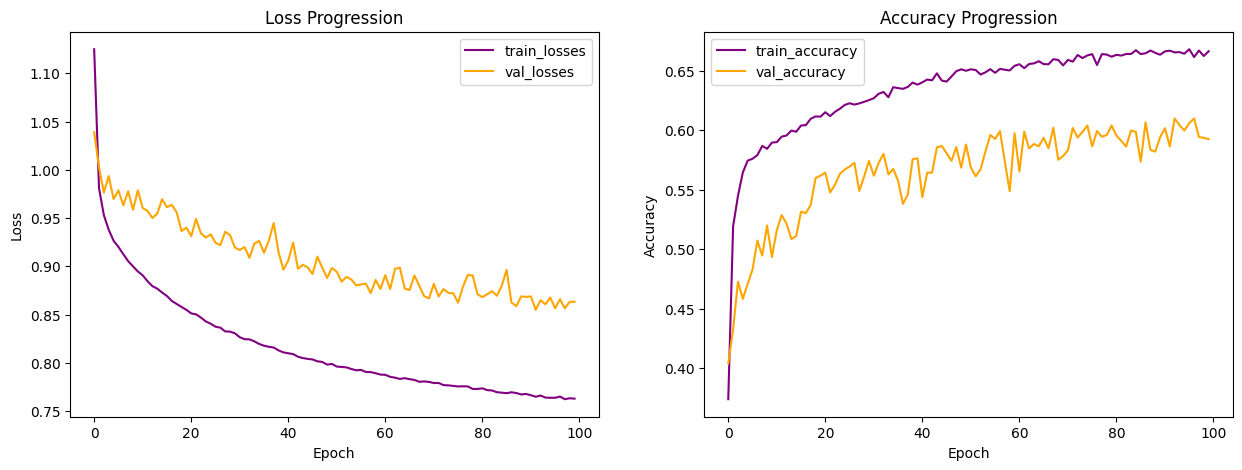

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_rms_continents'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 1ms/step - loss: 0.7590 - accuracy: 0.6701


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_rms_continents'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 1ms/step - loss: 0.8633 - accuracy: 0.5925


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.77      0.62      0.69      2758
      comsan       0.71      0.72      0.71      2730
     eaywag1       0.57      0.67      0.61      2748

    accuracy                           0.67      8236
   macro avg       0.68      0.67      0.67      8236
weighted avg       0.68      0.67      0.67      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.81      0.51      0.63      1760
      comsan       0.56      0.65      0.60      1112
     eaywag1       0.48      0.65      0.55      1364

    accuracy                           0.59      4236
   macro avg       0.62      0.60      0.59      4236
weighted avg       0.64      0.59      0.60      4236



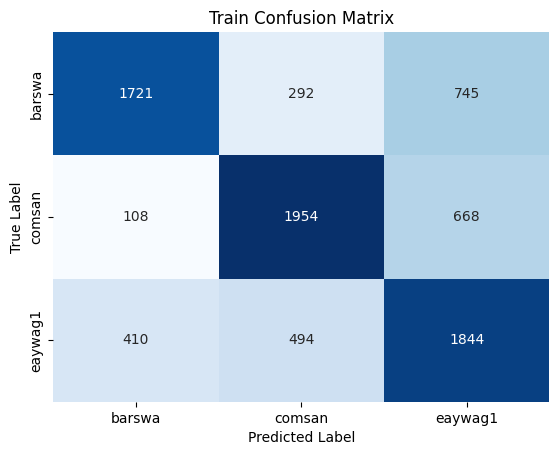

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

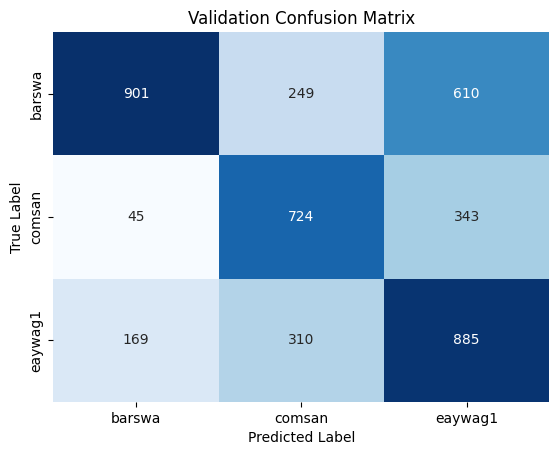

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

## With melspectrogram & spectral_centroid & continents

### create features

In [ ]:
training_features = np.concatenate((audio_df['train']['melspectrogram'], audio_df['train']['spectral_centroid'], non_audio_df['train']['continent']), axis=1)

training_features

array([[0.53896224, 0.5382145 , 0.54858524, ..., 0.        , 1.        ,
        0.        ],
       [0.67664582, 0.68223429, 0.62790626, ..., 0.        , 1.        ,
        0.        ],
       [0.42924321, 0.54093879, 0.55082095, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.40457806, 0.42597717, 0.43862545, ..., 0.        , 1.        ,
        0.        ],
       [0.63924813, 0.58731204, 0.56138533, ..., 0.        , 1.        ,
        0.        ],
       [0.76436812, 0.78159451, 0.75570196, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
training_features.shape

(8236, 26)

In [ ]:
validation_features = np.concatenate((audio_df['val']['melspectrogram'], audio_df['val']['spectral_centroid'], non_audio_df['val']['continent']), axis=1)

validation_features

array([[0.51499027, 0.55659962, 0.56469846, ..., 0.        , 1.        ,
        0.        ],
       [0.43145022, 0.52464581, 0.54172117, ..., 0.        , 1.        ,
        0.        ],
       [0.74679291, 0.76816022, 0.74579263, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.56870776, 0.60384142, 0.58420295, ..., 0.        , 1.        ,
        0.        ],
       [0.47650301, 0.45110127, 0.44740814, ..., 0.        , 0.        ,
        1.        ],
       [0.68796349, 0.62703204, 0.60789555, ..., 0.        , 1.        ,
        0.        ]])

In [ ]:
validation_features.shape

(4236, 26)

### fit the model with training data

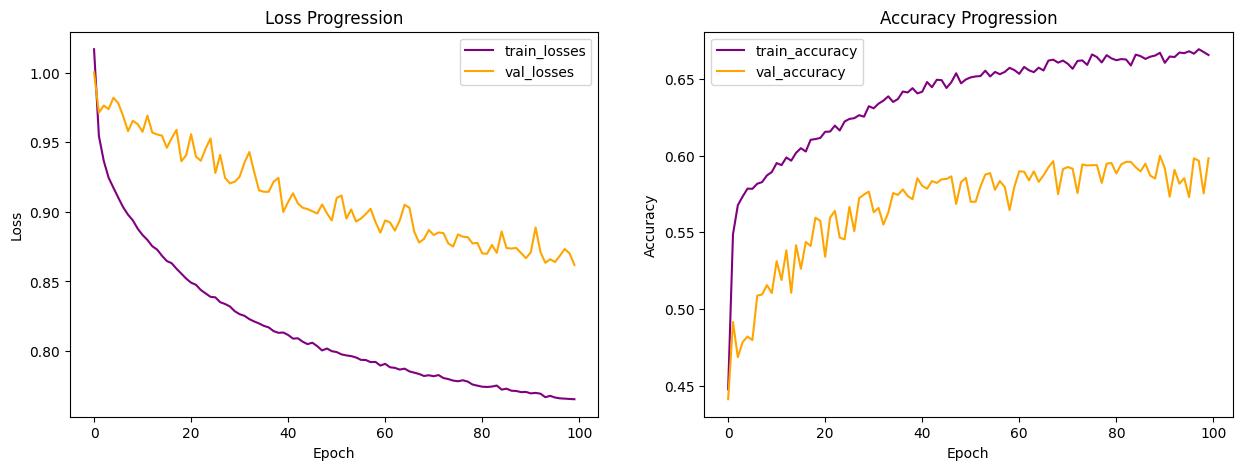

In [ ]:
model = build_model(training_features, learning_rate=0.005)

history = model.fit(
    x=training_features,
    y=audio_df['train']['label'],
    epochs=100,
    validation_data=(
        validation_features,
        audio_df['val']['label'],
    ),
    batch_size=32,
    verbose=0
)

visualize(history)

In [ ]:
train_yhat = model.predict(training_features)
train_yhat_result = np.argmax(train_yhat, axis=-1)
train_results['melspectrogram_spectral_centroid_continents'] = model.evaluate(training_features, audio_df['train']['label'])[-1]

258/258 [==============================] - 0s 2ms/step - loss: 0.7705 - accuracy: 0.6602


In [ ]:
val_yhat = model.predict(validation_features)
val_yhat_result = np.argmax(val_yhat, axis=-1)
val_results['melspectrogram_spectral_centroid_continents'] = model.evaluate(validation_features, audio_df['val']['label'])[-1]

133/133 [==============================] - 0s 1ms/step - loss: 0.8618 - accuracy: 0.5982


### evaluate the results

In [ ]:
print('Training classification Report \n')
print(classification_report(audio_df['train']['label'], train_yhat_result, target_names=classes))

Training classification Report 

              precision    recall  f1-score   support

      barswa       0.70      0.66      0.68      2758
      comsan       0.81      0.63      0.71      2730
     eaywag1       0.54      0.69      0.60      2748

    accuracy                           0.66      8236
   macro avg       0.68      0.66      0.66      8236
weighted avg       0.68      0.66      0.66      8236



In [ ]:
print('Validation classification Report \n')
print(classification_report(audio_df['val']['label'], val_yhat_result, target_names=classes))

Validation classification Report 

              precision    recall  f1-score   support

      barswa       0.72      0.55      0.62      1760
      comsan       0.69      0.56      0.62      1112
     eaywag1       0.48      0.69      0.56      1364

    accuracy                           0.60      4236
   macro avg       0.63      0.60      0.60      4236
weighted avg       0.63      0.60      0.60      4236



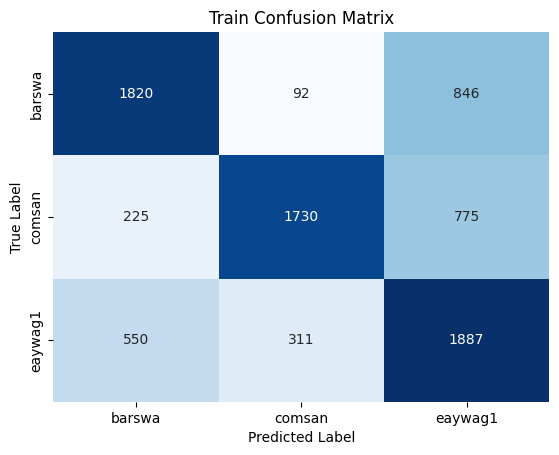

In [ ]:
train_cm = tf.math.confusion_matrix(audio_df['train']['label'], train_yhat_result)

ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Train Confusion Matrix')
plt.show()

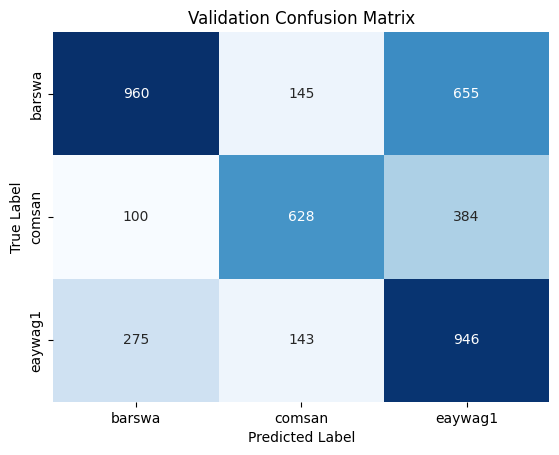

In [ ]:
val_cm = tf.math.confusion_matrix(audio_df['val']['label'], val_yhat_result)

ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Validation Confusion Matrix')
plt.show()

# Review results from all models

In [ ]:
train_results_df = pd.DataFrame(list(train_results.items()), columns=['Features', 'Train_Accuracy']).round(2)
val_results_df = pd.DataFrame(list(val_results.items()), columns=['Features', 'Val_Accuracy']).round(2)

result_df = train_results_df.merge(val_results_df, on='Features')
result_df = result_df.sort_values('Val_Accuracy')
result_df

,Features,Train_Accuracy,Val_Accuracy
2,chroma,0.50,0.40
3,rms_spectral_centroid,0.42,0.40
11,melspectrogram_chroma,0.64,0.54
4,melspectrogram,0.64,0.56
12,melspectrogram_chroma_continents,0.66,0.57
6,mfcc_chroma,0.69,0.58
13,melspectrogram_rms_spectral_centroid,0.65,0.58
1,mfcc,0.67,0.59
14,melspectrogram_rms_continents,0.67,0.59
8,mfcc_rms_spectral_centroid,0.68,0.60
